# Import Necessary Libraries

In [1]:
!pip install tensorflow==2.15 --user

In [2]:
# # Install the plot_keras_history package if not already installed
!pip install plot_keras_history
# Install the mlflow package if not already installed
!pip install mlflow
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from plot_keras_history import show_history
import mlflow
from mlflow.models import infer_signature
import numpy as np

# Loading Augumented Train Data

In [3]:
Data = np.load('A:\Jan-May 2024\CS5830-Big Data Laboratory\Main Project\Data\\augmented_fashion_mnist.npz')
(X_train, Y_train) = (Data['x_train'], Data['y_train'])
# Load the Fashion MNIST dataset from the Keras library and split it into training and testing sets
(X, Y), (X_test, Y_test) = tensorflow.keras.datasets.fashion_mnist.load_data()
# Define the number of classes in the dataset (in this case, there are 10 classes for the digits 0-9)
num_classes = 10
# Reshape the input data from 28x28 images to 1D arrays of length 784
x_train = X_train.reshape(60000, 784)  # Reshape training set
x_test = X_test.reshape(10000, 784)     # Reshape testing set
# Convert the data type of the input arrays to float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalize the input data by dividing by 255 (maximum pixel value)
x_train /= 255
x_test /= 255
# Print the shape of the training and testing input samples
print(x_train.shape, 'train input samples')
print(x_test.shape, 'test input samples')

(60000, 784) train input samples
(10000, 784) test input samples


In [4]:
# Convert the integer class labels to one-hot encoded vectors using to_categorical function from keras.utils
y_train = keras.utils.to_categorical(Y_train, num_classes)  # Convert training labels
y_test = keras.utils.to_categorical(Y_test, num_classes)    # Convert testing labels
# Print the shape of the training and testing output samples
print(y_train.shape, 'train output samples')
print(y_test.shape, 'test output samples')

(60000, 10) train output samples
(10000, 10) test output samples


# Data Visualisation

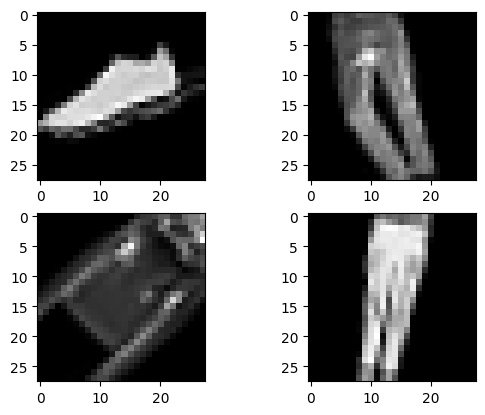

In [5]:
# Create subplots with 2 rows and 2 columns
plt.subplot(221)  # Subplot 1
plt.imshow(X_train[310], cmap=plt.get_cmap('gray'))  # Display the image at index 310 in grayscale
plt.subplot(222)  # Subplot 2
plt.imshow(X_train[515], cmap=plt.get_cmap('gray'))  # Display the image at index 515 in grayscale
plt.subplot(223)  # Subplot 3
plt.imshow(X_train[1210], cmap=plt.get_cmap('gray'))  # Display the image at index 1210 in grayscale
plt.subplot(224)  # Subplot 4
plt.imshow(X_train[2150], cmap=plt.get_cmap('gray'))  # Display the image at index 2150 in grayscale
# Show the plot with all subplots
plt.show()

# Define a function to build and train the model for all experiments

In [6]:
from keras.layers import Dropout

In [7]:
def log_summary_to_mlflow(summary_text):
    # Simply print the summary text, as MLflow's log_text doesn't directly accept it
    print(summary_text)
def train_model(experiment_name, experiment, x_train, y_train, x_test, y_test, hidden_layers, learning_rate, optimizer, regularization, momentum=None, batch_size=None, dropout_rate=None):
  if mlflow.get_experiment_by_name(experiment_name) is None:
    mlflow.create_experiment(experiment_name)
  mlflow.set_experiment(experiment_name)
  # Start MLflow run
  with mlflow.start_run(run_name=experiment):
      # Build the neural network model
      model = keras.Sequential()
      model.add(layers.Dense(hidden_layers[0], activation='sigmoid', input_shape=(784,), kernel_regularizer=regularization))
      if dropout_rate is not None:
        model.add(Dropout(dropout_rate))
      for num_neurons in hidden_layers[1:]:
          model.add(layers.Dense(num_neurons, activation='sigmoid', kernel_regularizer=regularization))
          if dropout_rate is not None:
            model.add(Dropout(dropout_rate))
      model.add(layers.Dense(10, activation='softmax'))
      # Compile the model
      if momentum is not None:
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer(learning_rate=learning_rate, momentum=momentum),
                      metrics=['accuracy'])
      else:
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer(learning_rate=learning_rate),
                      metrics=['accuracy'])
      # Train the model
      history = model.fit(x_train, y_train,batch_size=batch_size, epochs=10, validation_data=(x_test, y_test))
      # Log model summary
      model.summary(print_fn=log_summary_to_mlflow)
      # Task-1: Modify the code to log metrics (loss, accuracy) etc
      loss, acc = model.evaluate(x_test, y_test, verbose=0)
      mlflow.log_metrics({'test_loss': loss, 'test_accuracy': acc})
      loss, acc = model.evaluate(x_train, y_train, verbose=0)
      mlflow.log_metrics({'train_loss': loss, 'train_accuracy': acc})
      # Task-2: Modify the code to log paramters (network configuration, learning rate, optimizer, regularization, etc).
      mlflow.log_params({'hidden_layers': hidden_layers,
                          'learning_rate': learning_rate,
                          'momentum': momentum,
                          'optimizer': optimizer.__name__,
                          'regularization': regularization,
                          'dropout_rate': dropout_rate,
                           'Batch_Size': batch_size})
      # Store error and accuracy plots as artifacts
      fig, axes = plt.subplots(2, 1, figsize=(10, 8))
      axes[0].plot(history.history['loss'], label='Training Loss')
      axes[0].plot(history.history['val_loss'], label='Validation Loss')
      axes[0].set_xlabel('Epochs')
      axes[0].set_ylabel('Loss')
      axes[0].legend()

      axes[1].plot(history.history['accuracy'], label='Training Accuracy')
      axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
      axes[1].set_xlabel('Epochs')
      axes[1].set_ylabel('Accuracy')
      axes[1].legend()
      plt.tight_layout()
      plt.savefig(f"{experiment}.png")  # Save the plot as PNG
      mlflow.log_artifact(f"{experiment}.png")  # Log the plot as artifact

# Set our tracking server uri for logging

In [8]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Experiment-1: Basic Neural Network for Classification


Epoch 1/10


1875/1875 [==============================] - 6s 3ms/step - loss: 1.6680 - accuracy: 0.4010 - val_loss: 1.1626 - val_accuracy: 0.5736
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.3010 - accuracy: 0.5160 - val_loss: 0.9824 - val_accuracy: 0.6430
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.1750 - accuracy: 0.5624 - val_loss: 0.9067 - val_accuracy: 0.6630
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.1089 - accuracy: 0.5855 - val_loss: 0.8644 - val_accuracy: 0.6696
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.0689 - accuracy: 0.6007 - val_loss: 0.8430 - val_accuracy: 0.6818
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.0432 - accuracy: 0.6103 - val_loss: 0.8209 - val_accuracy: 0.6817
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 1.0239 - accuracy: 0.6151 - val_loss: 0.8249 - val_accura

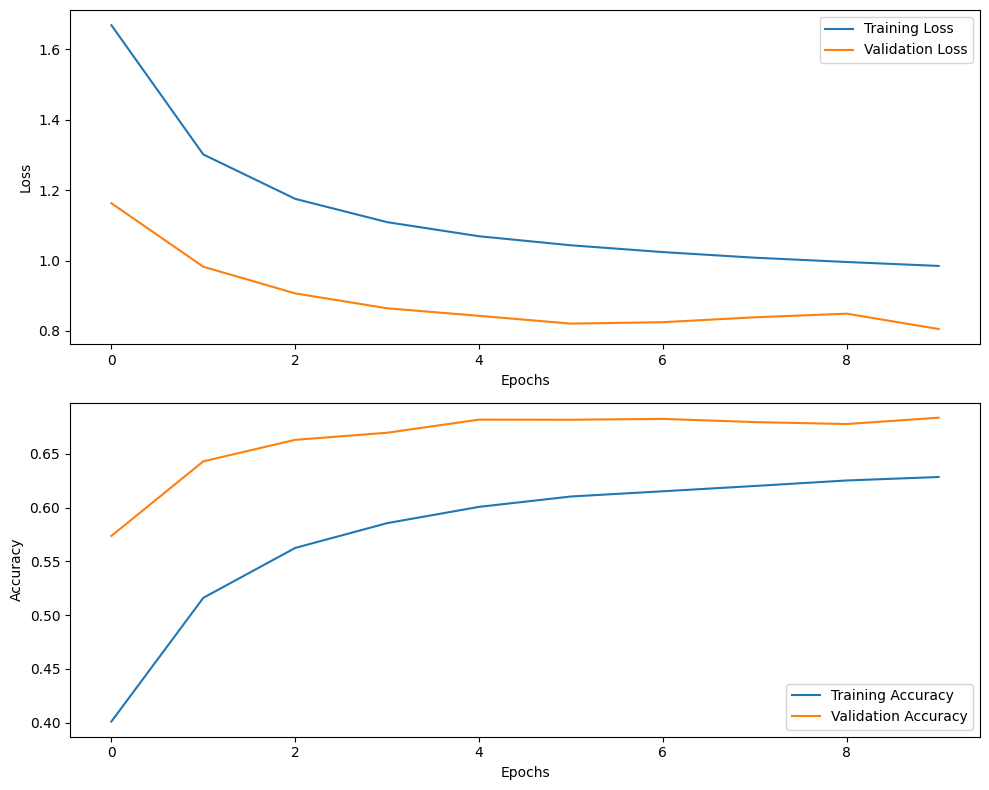

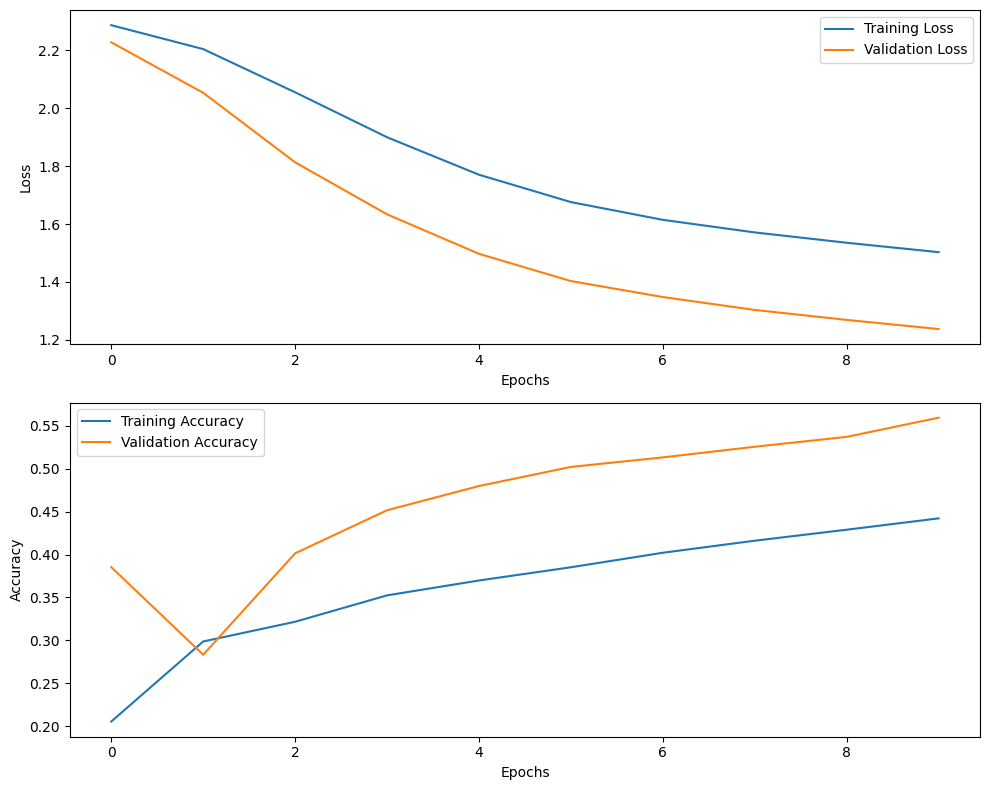

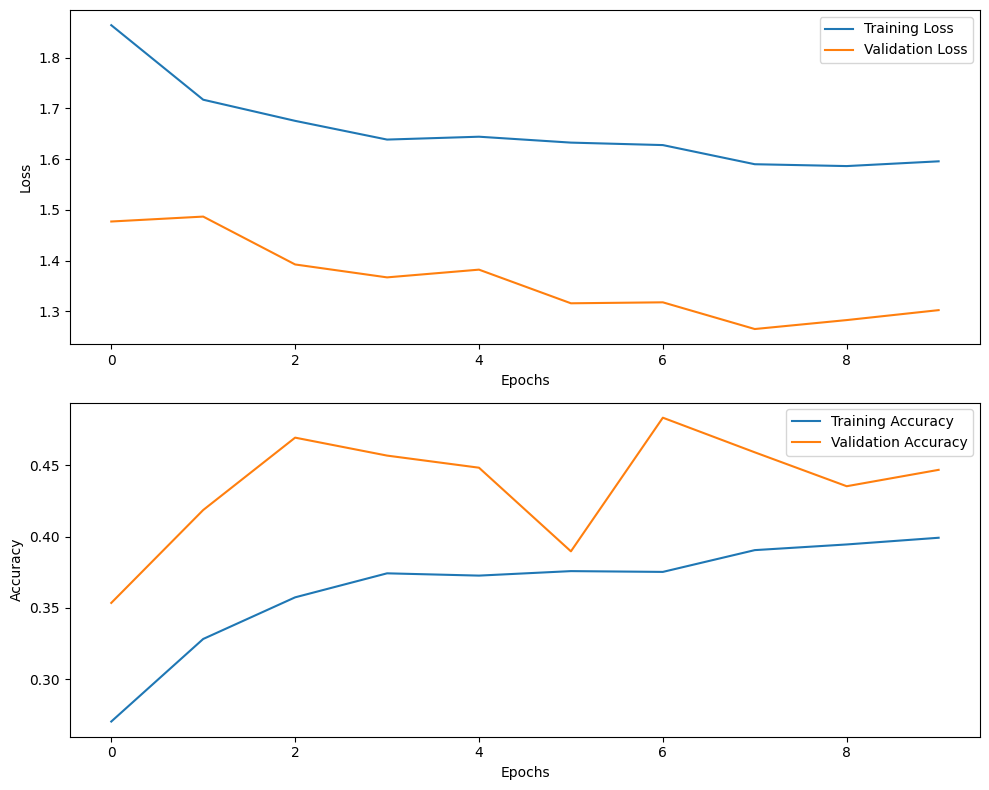

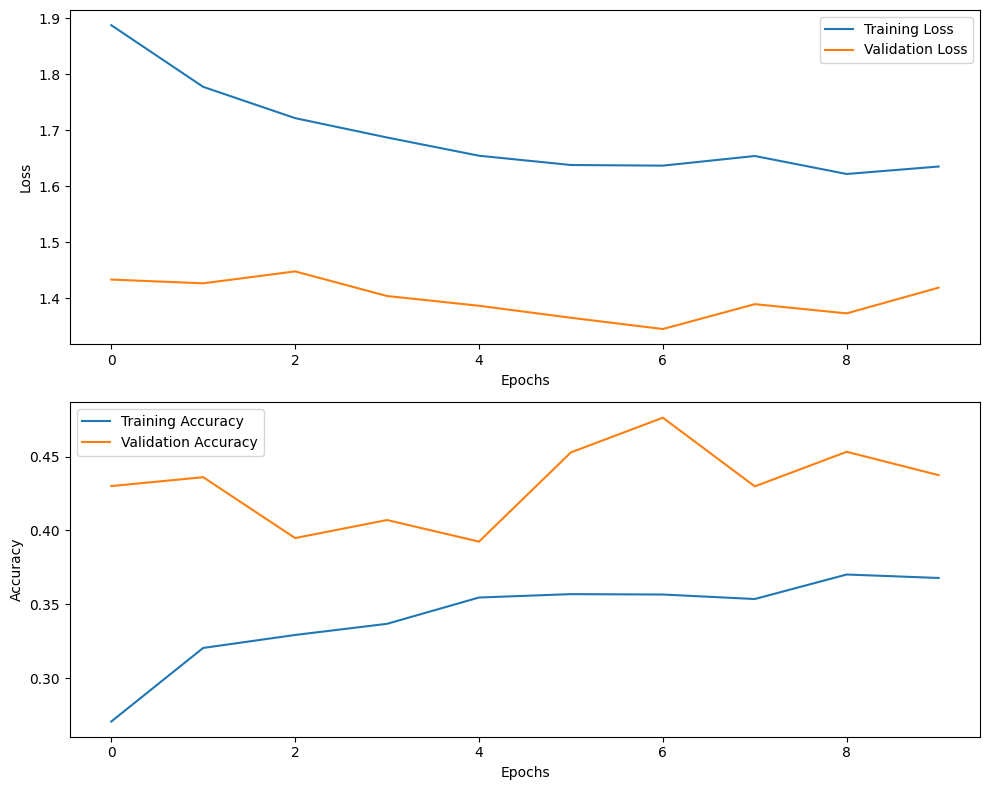

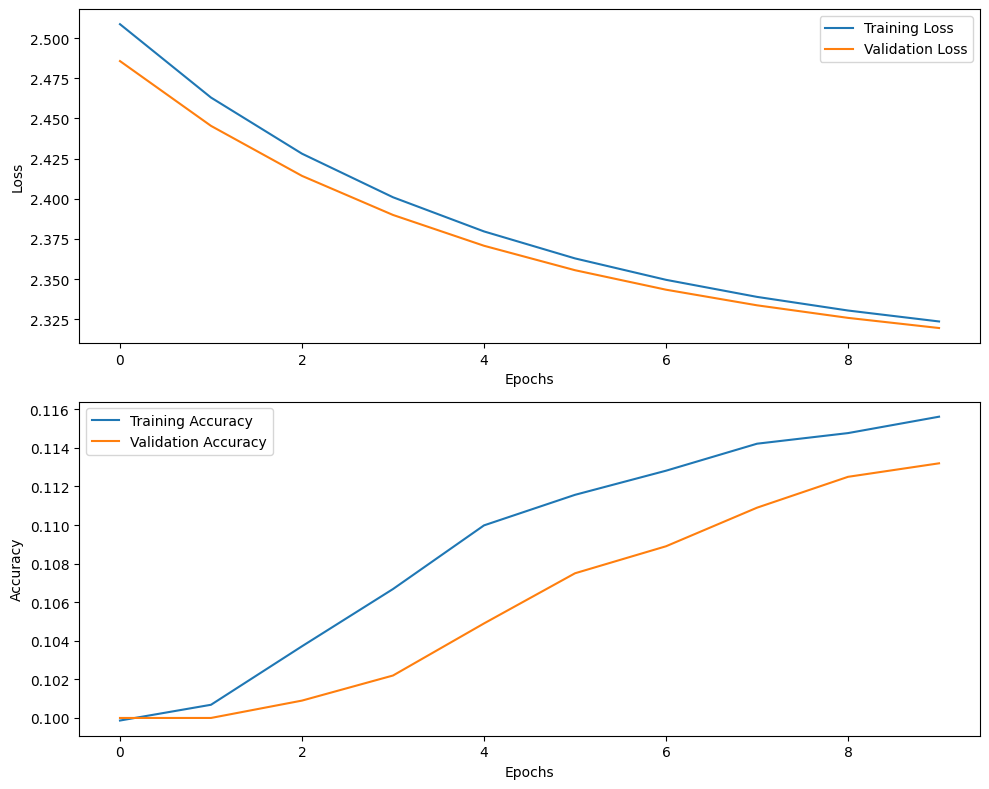

In [9]:
# Experiment name
experiment_name = "Experiment-1: Basic Neural Network for Classification"
# Define sub-experiments
experiment = ['Sub Experiment-1', 'Sub Experiment-2', 'Sub Experiment-3', 'Sub Experiment-4', 'Sub Experiment-5']
# Define neural network architecture
hidden_layers = [20, 20]  # Two hidden layers with 20 neurons each
# Define learning rates for each sub-experiment
learning_rate = [0.001, 0.01, 0.1, 0.05, 0.0001]
# Define optimizers for each sub-experiment
optimizers = [keras.optimizers.Adam, keras.optimizers.SGD, keras.optimizers.RMSprop, keras.optimizers.Adam, keras.optimizers.SGD]
# Iterate over each sub-experiment
for parameter in experiment:
    # Train model for the current sub-experiment
    # Call the train_model function with experiment parameters
    train_model(
        experiment_name,  # Experiment name
        parameter,  # Sub-experiment name
        x_train, y_train,  # Training data
        x_test, y_test,  # Testing data
        hidden_layers,  # Neural network architecture
        learning_rate[experiment.index(parameter)],  # Learning rate for current sub-experiment
        optimizers[experiment.index(parameter)],  # Optimizer for current sub-experiment
        None, # Regularization is not needed in Experiment-1
        momentum = None, # No momentum required in this experiment
        batch_size=None, # No batch size in this experiment
        dropout_rate=None
        
    )


# Experiment-2: Slightly bigger model with more parameters

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 1.2187 - accuracy: 0.5521 - val_loss: 0.7813 - val_accuracy: 0.7001
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.9231 - accuracy: 0.6486 - val_loss: 0.7207 - val_accuracy: 0.7277
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.8345 - accuracy: 0.6823 - val_loss: 0.6904 - val_accuracy: 0.7366
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7778 - accuracy: 0.7027 - val_loss: 0.6726 - val_accuracy: 0.7542
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.7392 - accuracy: 0.7178 - val_loss: 0.6427 - val_accuracy: 0.7542
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.7013 - accuracy: 0.7313 - val_loss: 0.6638 - val_accuracy: 0.7523
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6703 - accuracy: 0.7443 - val_loss: 0.6403 - val_accuracy:

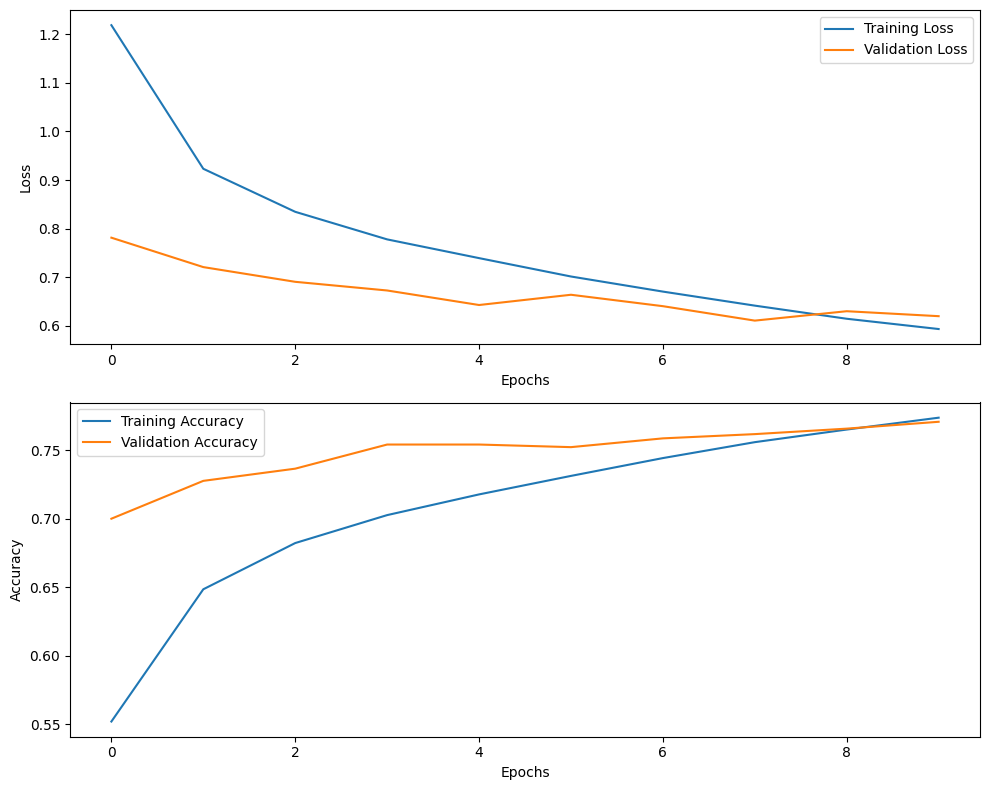

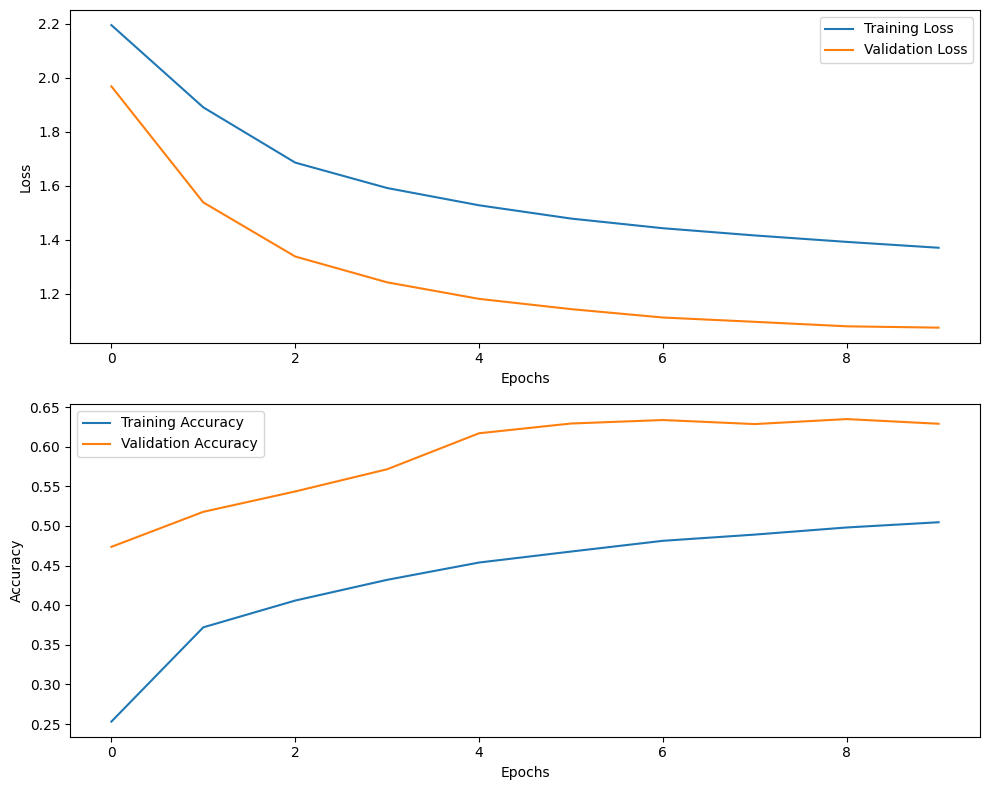

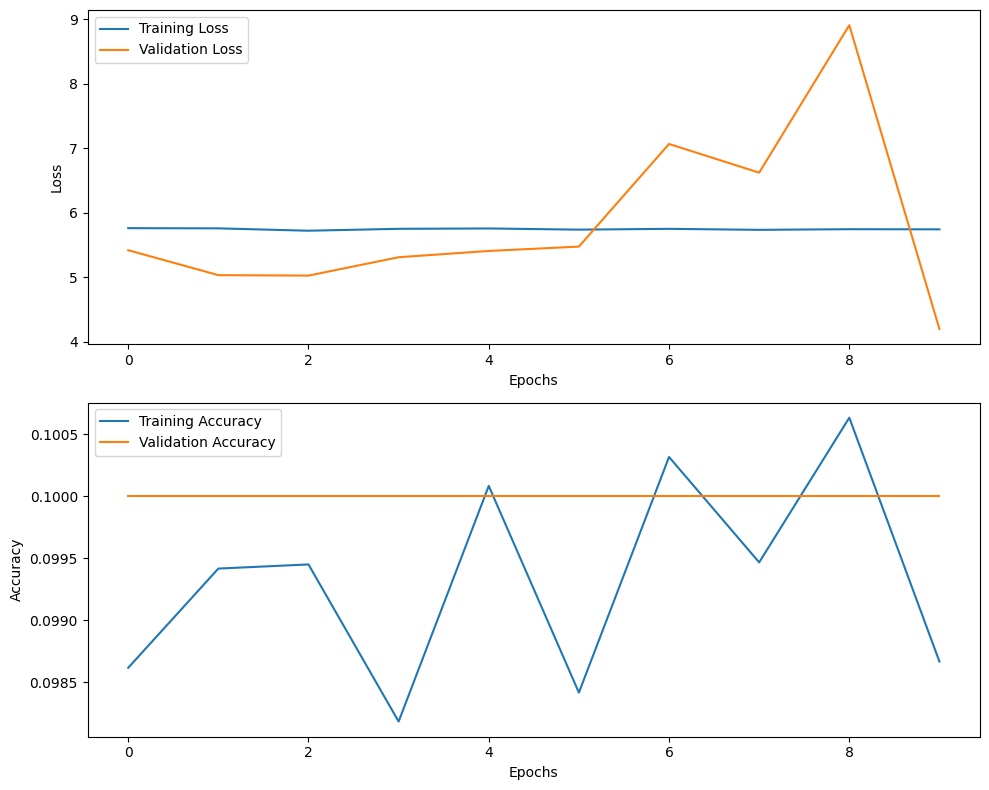

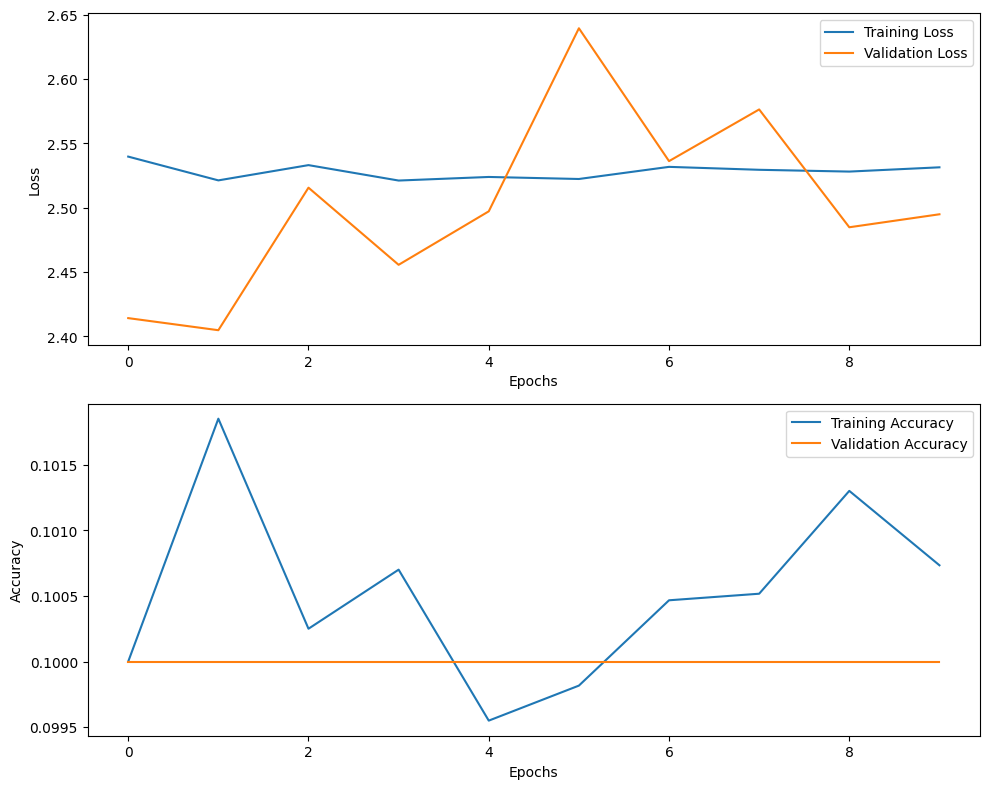

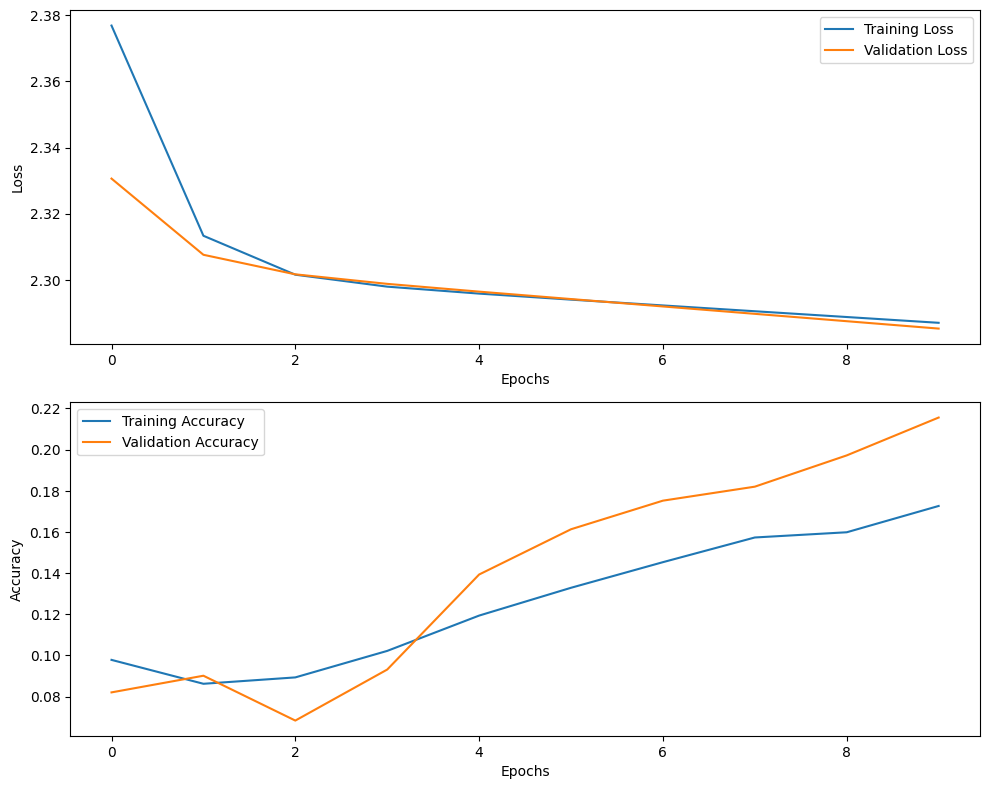

In [10]:
# Experiment name
experiment_name = "Experiment-2: Slightly bigger model with more parameters"
# Define sub-experiments
experiment = ['Sub Experiment-1', 'Sub Experiment-2', 'Sub Experiment-3', 'Sub Experiment-4', 'Sub Experiment-5']
# Define neural network architecture
hidden_layers = [256, 128]  # Two hidden layers as defined in notebook given
# Define learning rates for each sub-experiment
learning_rate = [0.001, 0.01, 0.1, 0.05, 0.0001]
# Define optimizers for each sub-experiment
optimizers = [keras.optimizers.Adam, keras.optimizers.SGD, keras.optimizers.RMSprop, keras.optimizers.Adam, keras.optimizers.SGD]
# Iterate over each sub-experiment
for parameter in experiment:
    # Train model for the current sub-experiment
    # Call the train_model function with experiment parameters
    train_model(
        experiment_name,  # Experiment name
        parameter,  # Sub-experiment name
        x_train, y_train,  # Training data
        x_test, y_test,  # Testing data
        hidden_layers,  # Neural network architecture
        learning_rate[experiment.index(parameter)],  # Learning rate for current sub-experiment
        optimizers[experiment.index(parameter)],  # Optimizer for current sub-experiment
        None, # Regularization is not needed in experiment-2
        momentum = None, # No momentum required in this experiment
        batch_size=None, # No batch size in this experiment
        dropout_rate=None
    )

# Experiment-3: Adding Kernel regularization to the mix

In [11]:
from keras import regularizers

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 2.1741 - accuracy: 0.3011 - val_loss: 1.7506 - val_accuracy: 0.4797
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.9498 - accuracy: 0.3287 - val_loss: 1.6468 - val_accuracy: 0.3862
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.9105 - accuracy: 0.3576 - val_loss: 1.6223 - val_accuracy: 0.5396
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.8759 - accuracy: 0.3783 - val_loss: 1.5749 - val_accuracy: 0.5220
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.8528 - accuracy: 0.3819 - val_loss: 1.5723 - val_accuracy: 0.5283
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.8357 - accuracy: 0.3841 - val_loss: 1.5846 - val_accuracy: 0.4864
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.8227 - accuracy: 0.3883 - val_loss: 1.5209 - val_accuracy:

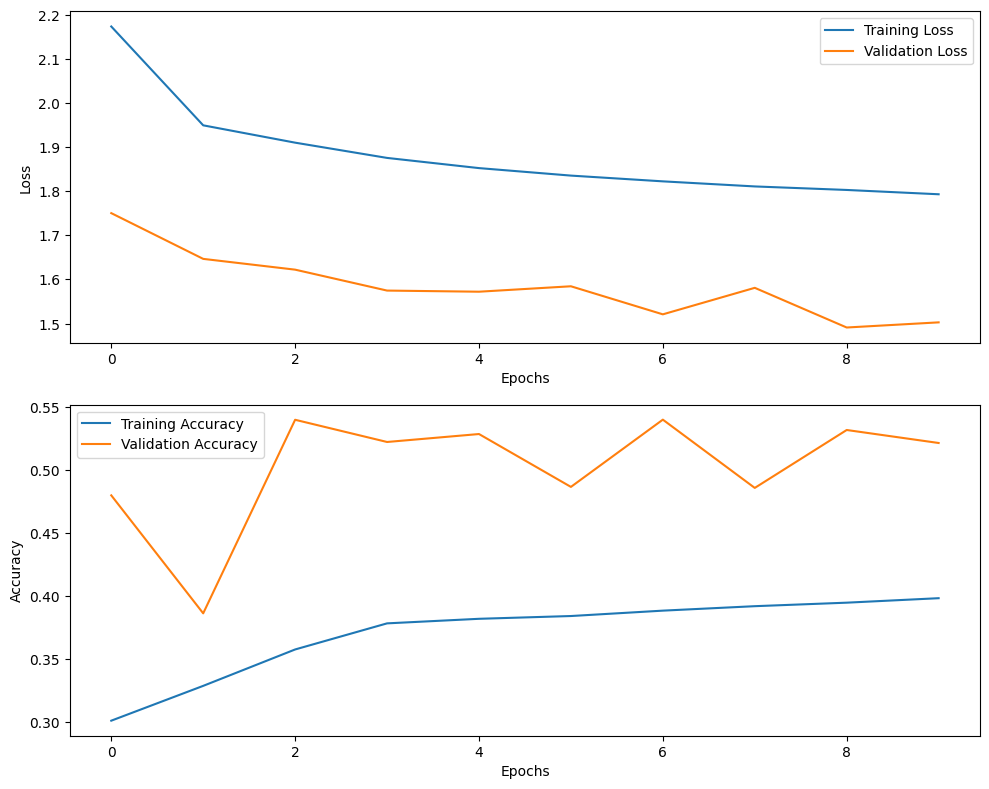

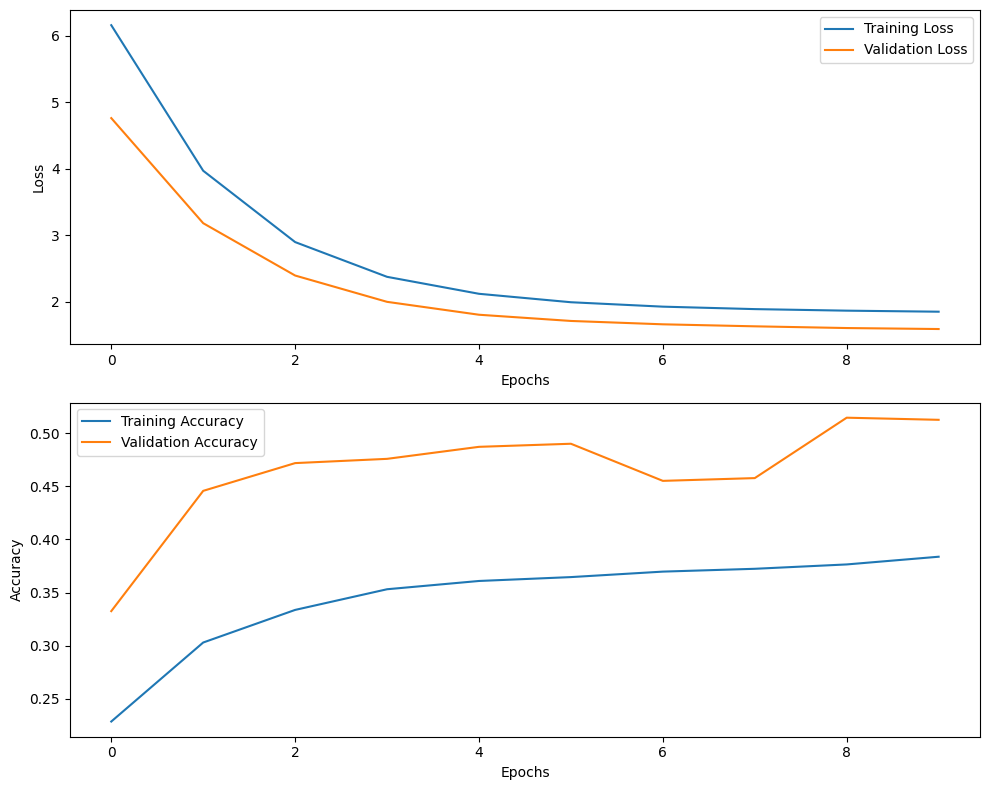

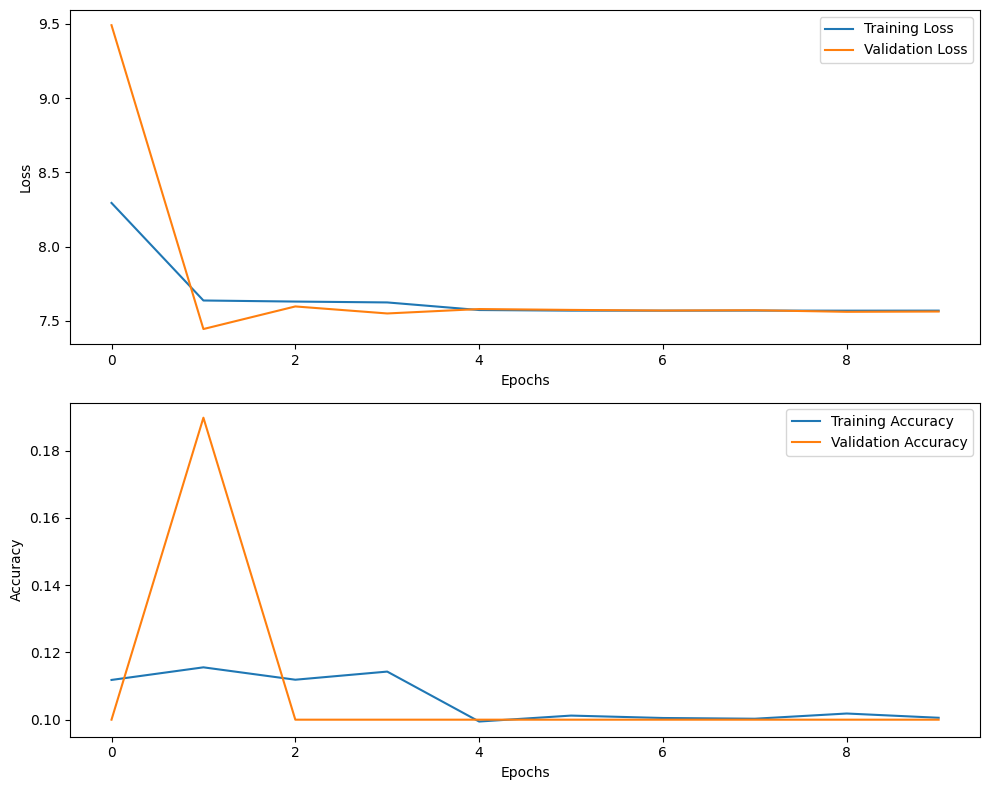

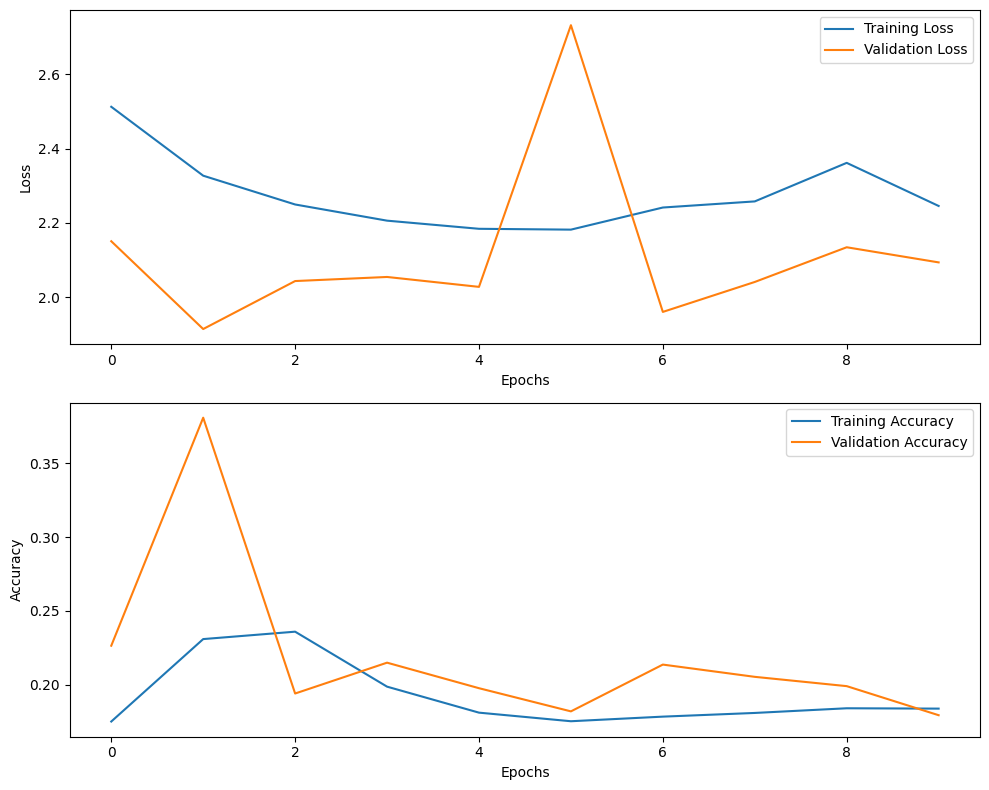

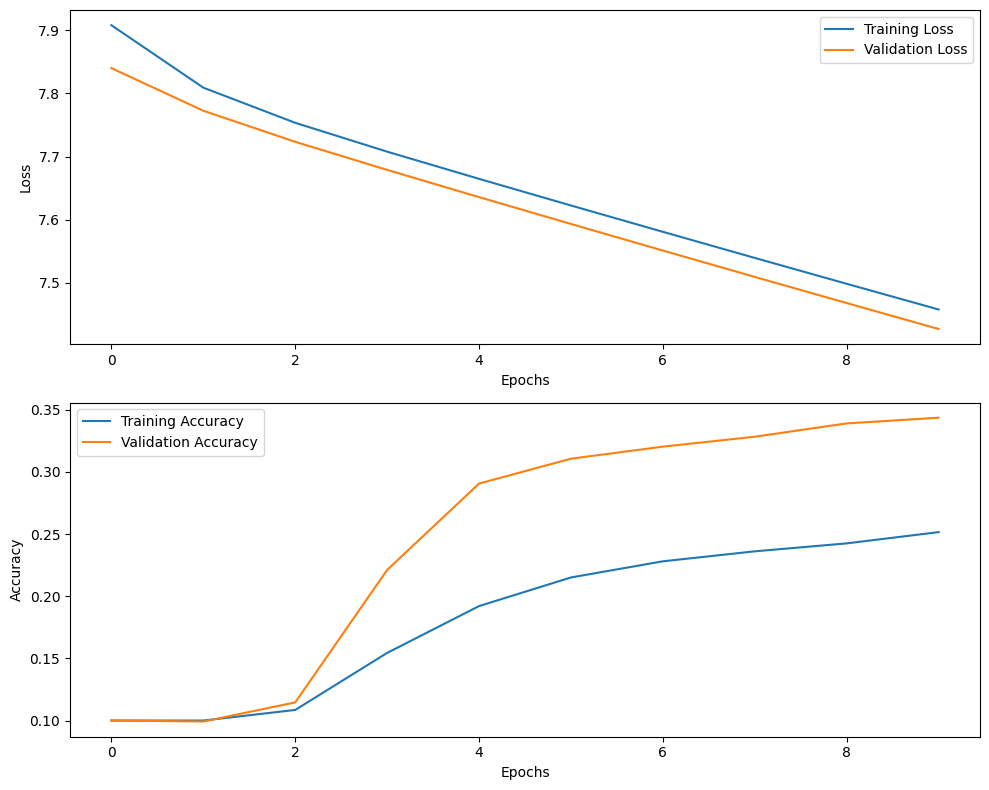

In [12]:
# Experiment name
experiment_name = "Experiment-3: Adding Kernel regularization to the mix"
# Define sub-experiments
experiment = ['Sub Experiment-1', 'Sub Experiment-2', 'Sub Experiment-3', 'Sub Experiment-4', 'Sub Experiment-5']
# Define neural network architecture
hidden_layers = [256, 128]  # Two hidden layers as defined in notebook given
# Define learning rates for each sub-experiment
learning_rate = [0.001, 0.01, 0.1, 0.05, 0.0001]
# Define optimizers for each sub-experiment
optimizers = [keras.optimizers.Adam, keras.optimizers.SGD, keras.optimizers.RMSprop, keras.optimizers.Adam, keras.optimizers.SGD]
# Iterate over each sub-experiment
for parameter in experiment:
    # Train model for the current sub-experiment
    # Call the train_model function with experiment parameters
    train_model(
        experiment_name,  # Experiment name
        parameter,  # Sub-experiment name
        x_train, y_train,  # Training data
        x_test, y_test,  # Testing data
        hidden_layers,  # Neural network architecture
        learning_rate[experiment.index(parameter)],  # Learning rate for current sub-experiment
        optimizers[experiment.index(parameter)],  # Optimizer for current sub-experiment
        regularization=regularizers.l2(0.01),# Regularization is needed in experiment-3
        momentum = None, # No momentum required in this experiment
        batch_size=None, # No batch size in this experiment
        dropout_rate=None
    )

# Experiment-4: With Dropout later

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 2.4874 - accuracy: 0.1799 - val_loss: 2.0247 - val_accuracy: 0.3082
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 2.2333 - accuracy: 0.2300 - val_loss: 1.9411 - val_accuracy: 0.3953
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 2.2187 - accuracy: 0.2437 - val_loss: 1.9120 - val_accuracy: 0.4189
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 2.2046 - accuracy: 0.2509 - val_loss: 1.8746 - val_accuracy: 0.4523
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 2.1965 - accuracy: 0.2562 - val_loss: 1.9175 - val_accuracy: 0.3622
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 2.1910 - accuracy: 0.2570 - val_loss: 1.8948 - val_accuracy: 0.4125
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 2.1863 - accuracy: 0.2610 - val_loss: 1.8571 - val_accuracy:

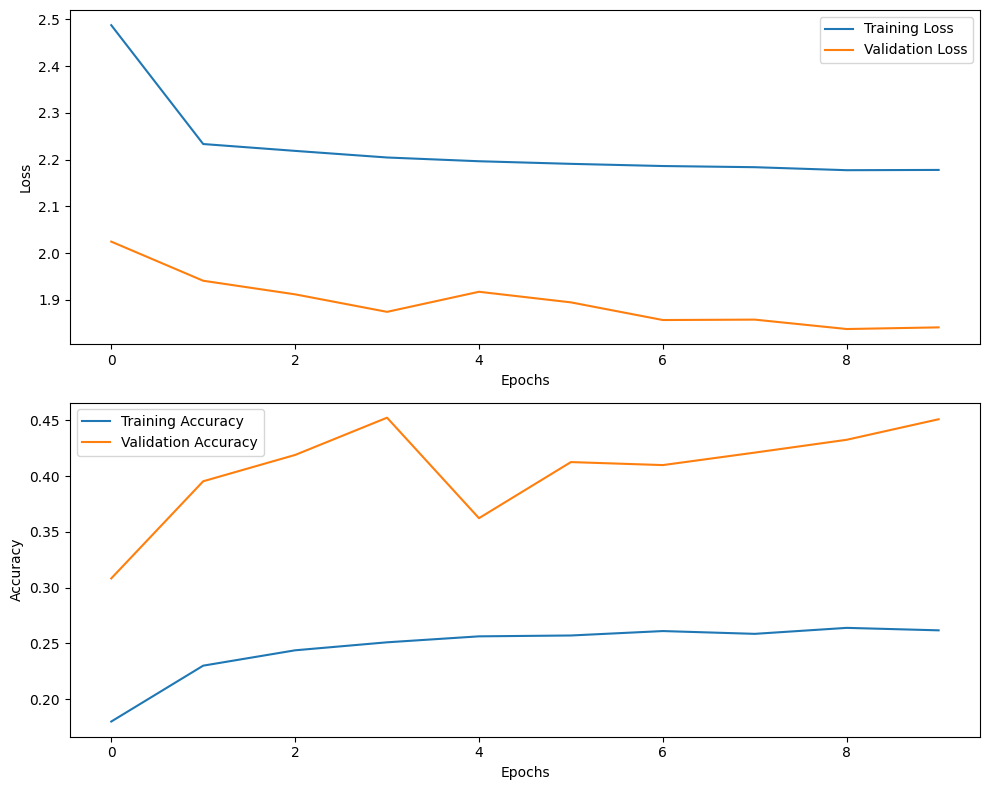

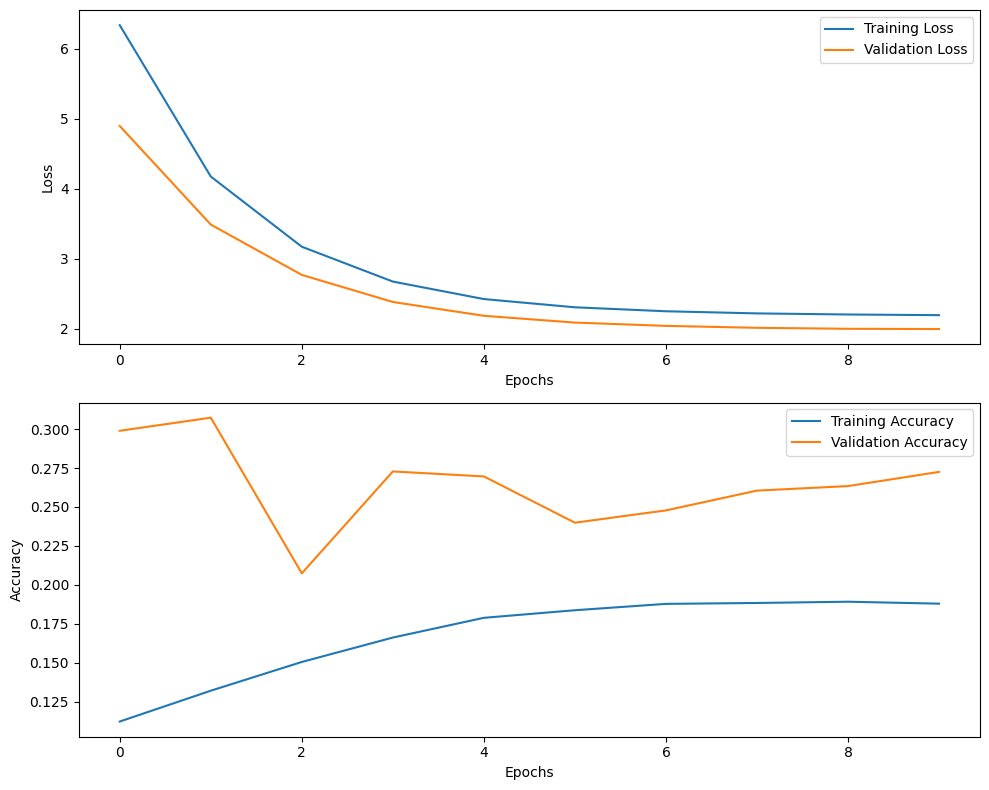

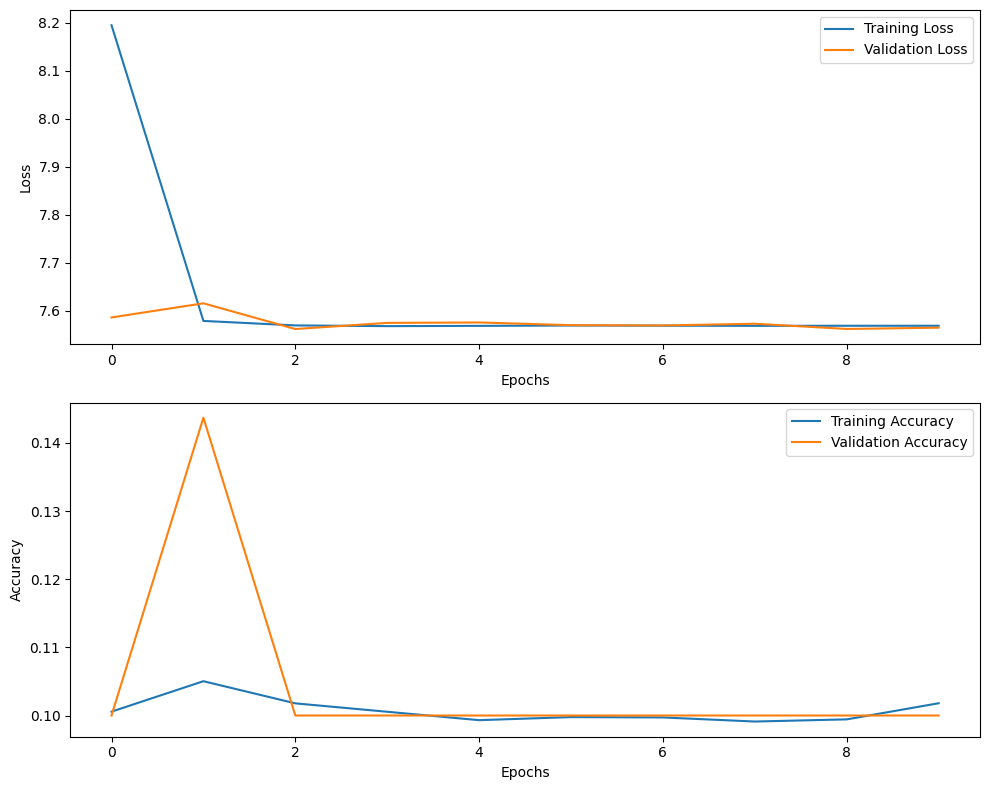

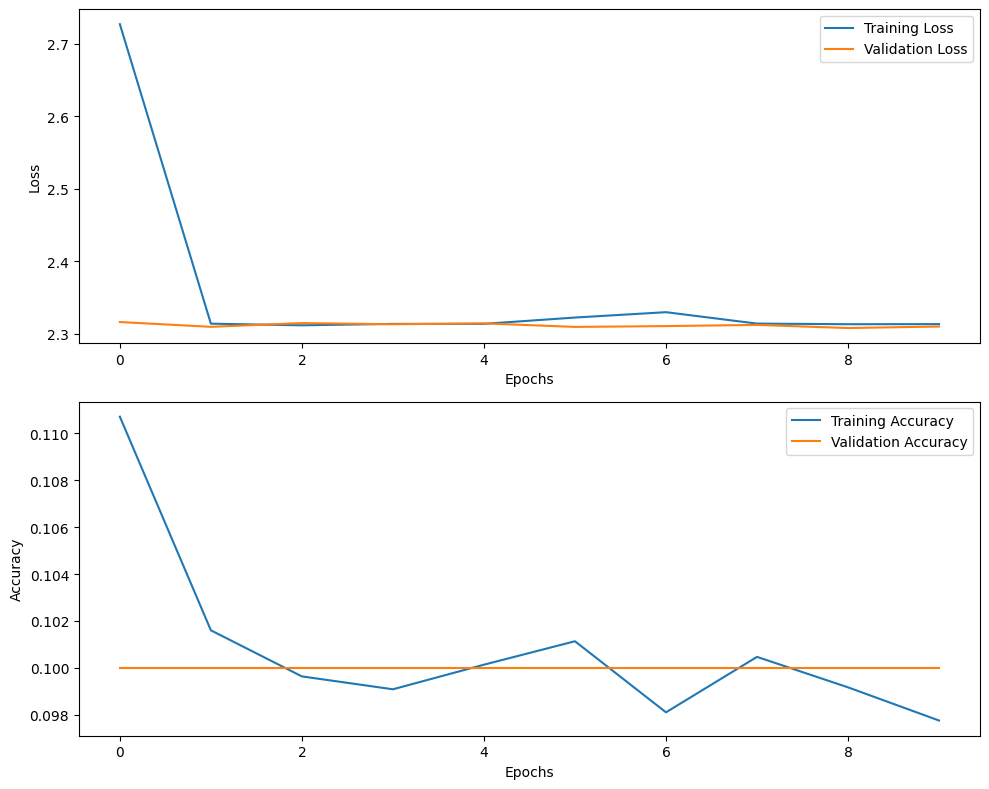

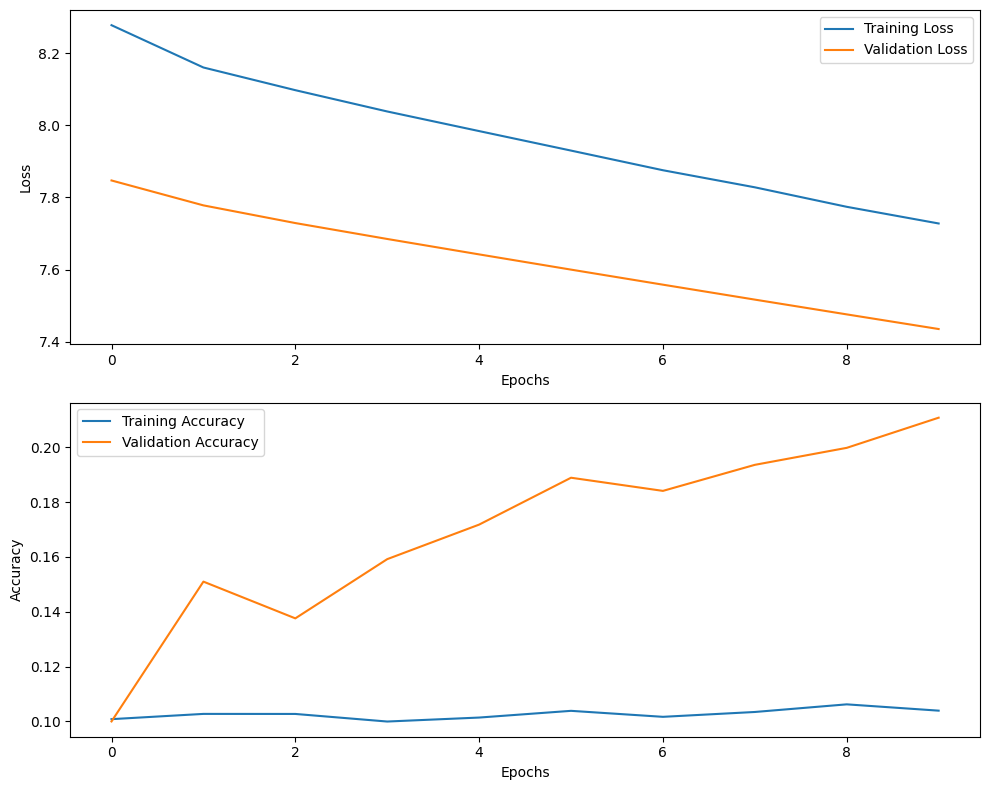

In [13]:
# Experiment name
experiment_name = "Experiment-4: With Dropout later"
# Define sub-experiments
experiment = ['Sub Experiment-1', 'Sub Experiment-2', 'Sub Experiment-3', 'Sub Experiment-4', 'Sub Experiment-5']
# Define neural network architecture
hidden_layers = [256, 128]  # Two hidden layers as defined in notebook given
# Define learning rates for each sub-experiment
learning_rate = [0.001, 0.01, 0.1, 0.05, 0.0001]
# Define optimizers for each sub-experiment
optimizers = [keras.optimizers.Adam, keras.optimizers.SGD, keras.optimizers.RMSprop, keras.optimizers.Adam, keras.optimizers.SGD]
dropout_rate = 0.6
# Iterate over each sub-experiment
for parameter in experiment:
    # Train model for the current sub-experiment
    # Call the train_model function with experiment parameters
    train_model(
        experiment_name,  # Experiment name
        parameter,  # Sub-experiment name
        x_train, y_train,  # Training data
        x_test, y_test,  # Testing data
        hidden_layers,  # Neural network architecture
        learning_rate[experiment.index(parameter)],  # Learning rate for current sub-experiment
        optimizers[experiment.index(parameter)],  # Optimizer for current sub-experiment
        regularization=regularizers.l2(0.01),# Regularization is needed in experiment-3
        momentum = None, # No momentum required in this experiment
        batch_size=None, # No batch size in this experiment
        dropout_rate = 0.6 # dropout layer is added in this experiment
    )

# Experiment - 5: Too low Learning rate with bigger model

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 2.3449 - accuracy: 0.1165 - val_loss: 2.3050 - val_accuracy: 0.1570
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 2.2993 - accuracy: 0.1408 - val_loss: 2.2588 - val_accuracy: 0.1590
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 2.2672 - accuracy: 0.1478 - val_loss: 2.2192 - val_accuracy: 0.1524
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 2.2410 - accuracy: 0.1791 - val_loss: 2.1885 - val_accuracy: 0.2672
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 2.2194 - accuracy: 0.2453 - val_loss: 2.1628 - val_accuracy: 0.3866
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 2.2005 - accuracy: 0.2937 - val_loss: 2.1397 - val_accuracy: 0.3988
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 2.1831 - accuracy: 0.3108 - val_loss: 2.1183 - val_accuracy:

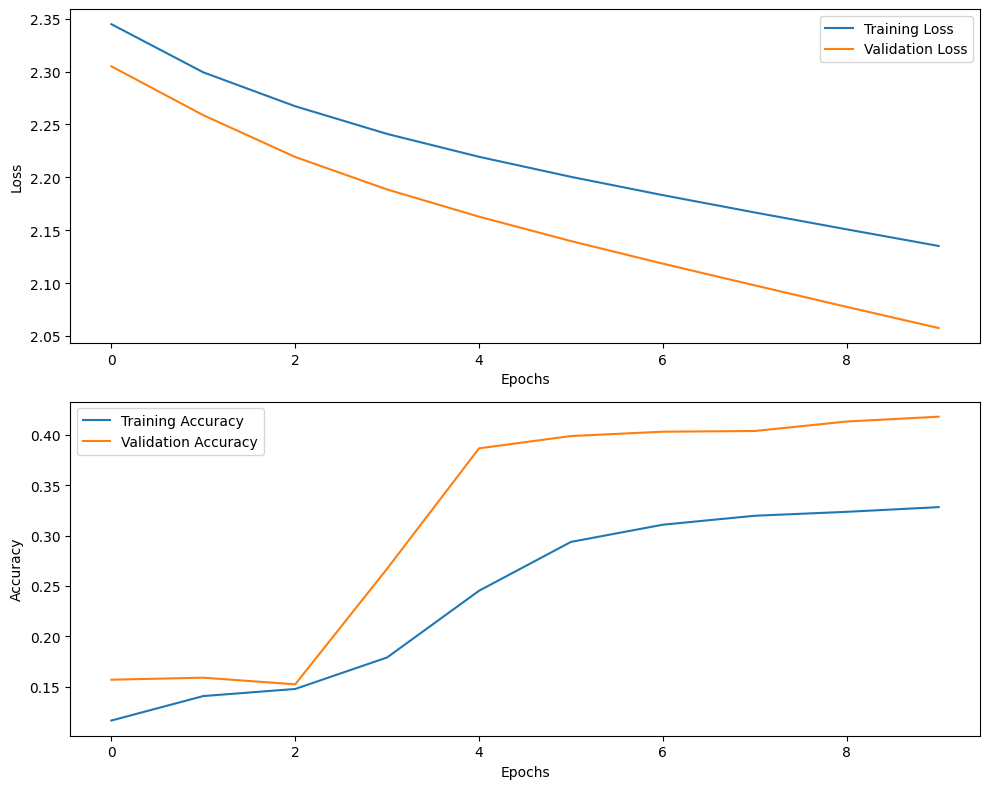

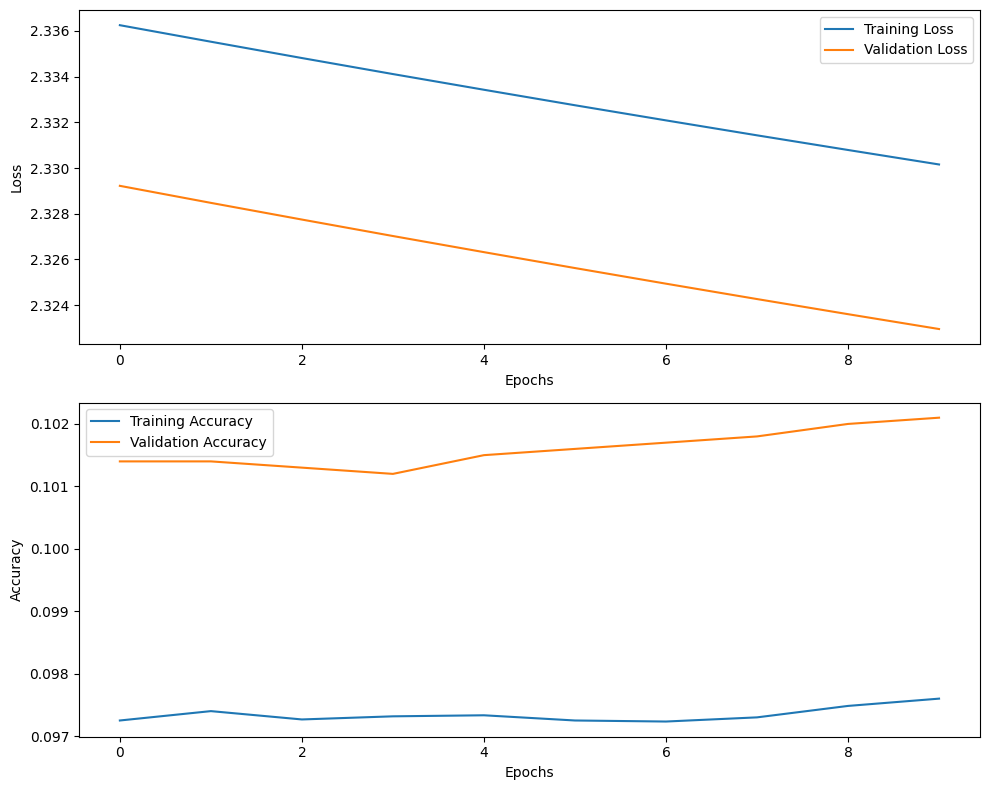

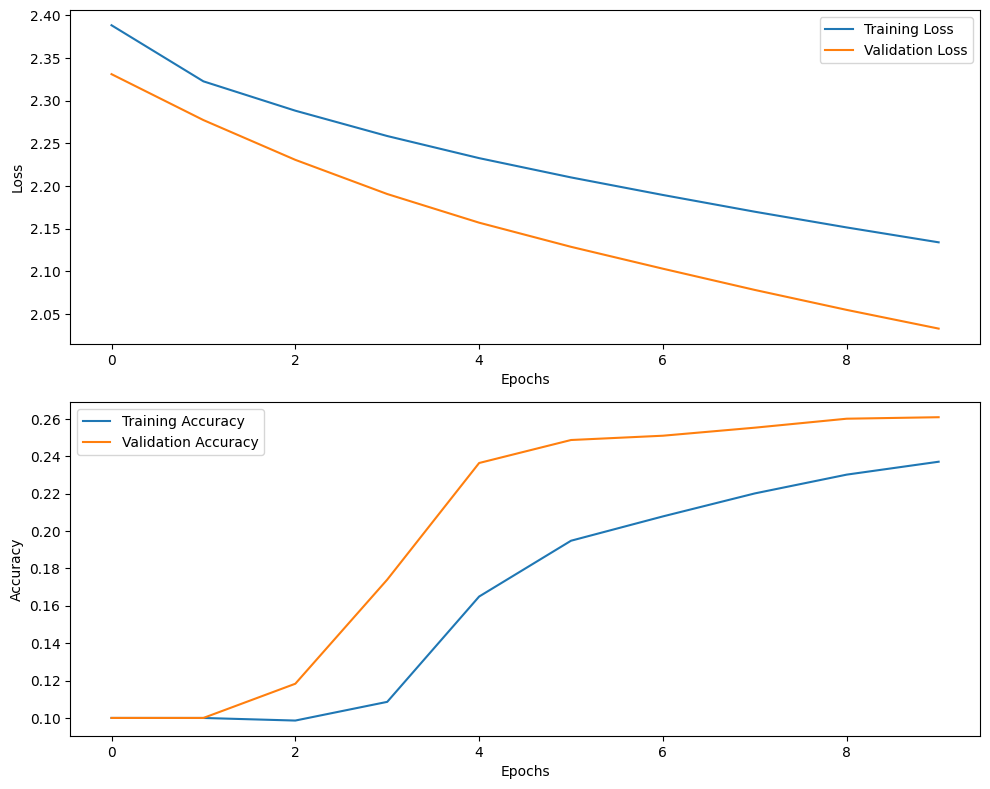

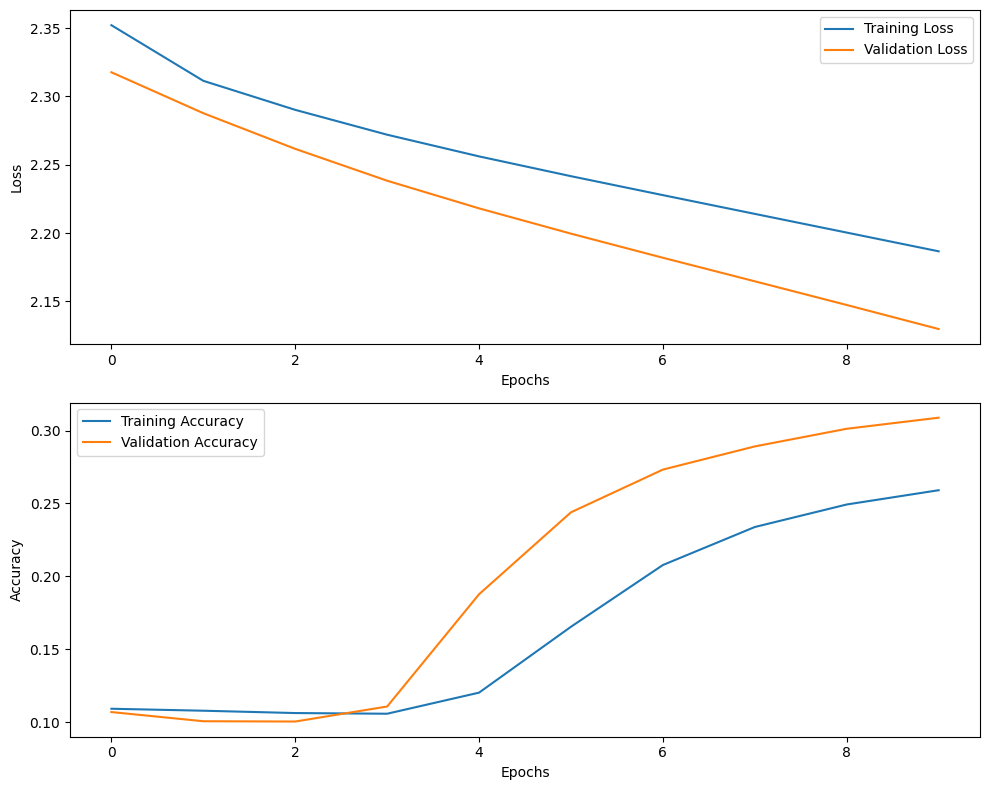

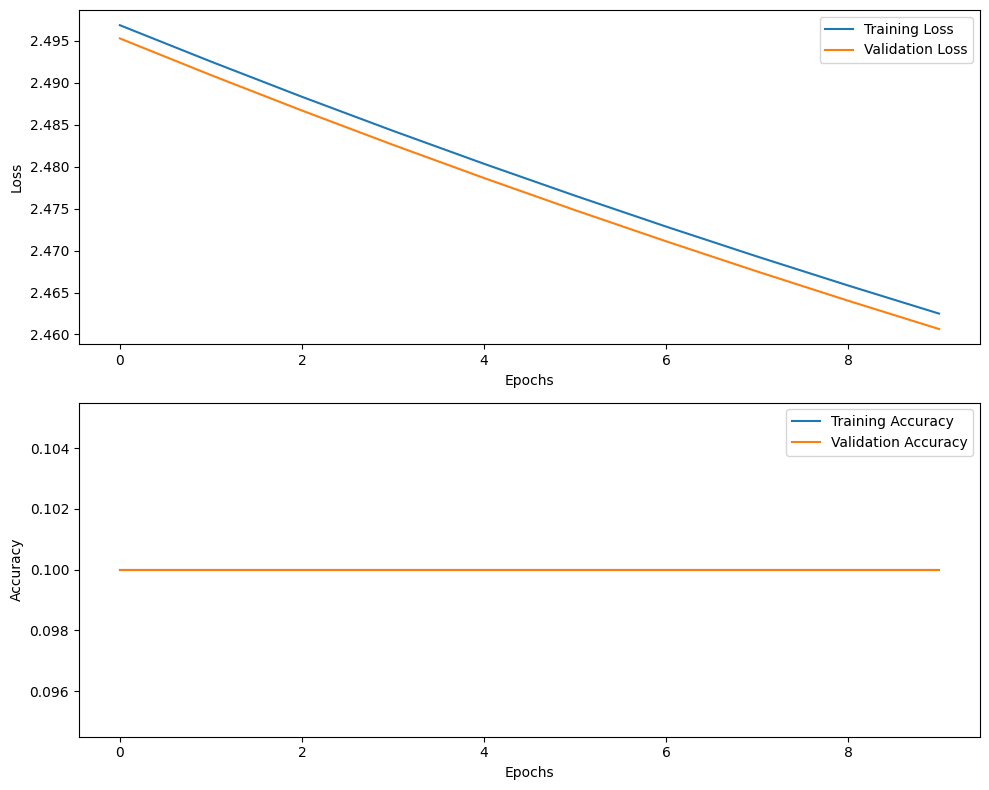

In [14]:
# Experiment name
experiment_name = "Experiment - 5: Too low Learning rate with bigger model"
# Define sub-experiments
experiment = ['Sub Experiment-1', 'Sub Experiment-2', 'Sub Experiment-3', 'Sub Experiment-4', 'Sub Experiment-5']
# Define neural network architecture
hidden_layers = [20, 10]  # Two hidden layers as defined in notebook given
# Define learning rates for each sub-experiment
learning_rate = 0.00001 # for too low learning rate
# Define optimizers for each sub-experiment
optimizers = [keras.optimizers.Adam, keras.optimizers.SGD, keras.optimizers.RMSprop, keras.optimizers.Adam, keras.optimizers.SGD]
# Iterate over each sub-experiment
for parameter in experiment:
    # Train model for the current sub-experiment
    # Call the train_model function with experiment parameters
    train_model(
        experiment_name,  # Experiment name
        parameter,  # Sub-experiment name
        x_train, y_train,  # Training data
        x_test, y_test,  # Testing data
        hidden_layers,  # Neural network architecture
        learning_rate,  # Learning rate
        optimizers[experiment.index(parameter)],  # Optimizer for current sub-experiment
        None, # Regularization is not needed in experiment-6
        momentum = None, # No momentum required in this experiment
        batch_size=None, # No batch size in this experiment
        dropout_rate=None
    )

# Experiment-6: Too low learning rate

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 2.3240 - accuracy: 0.1000 - val_loss: 2.2872 - val_accuracy: 0.1000
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 2.2866 - accuracy: 0.1000 - val_loss: 2.2509 - val_accuracy: 0.1000
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 2.2622 - accuracy: 0.1000 - val_loss: 2.2184 - val_accuracy: 0.1000
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 2.2404 - accuracy: 0.1001 - val_loss: 2.1881 - val_accuracy: 0.1001
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 2.2196 - accuracy: 0.1054 - val_loss: 2.1603 - val_accuracy: 0.1464
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 2.2002 - accuracy: 0.1575 - val_loss: 2.1342 - val_accuracy: 0.2255
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 2.1816 - accuracy: 0.2106 - val_loss: 2.1091 - val_accuracy:

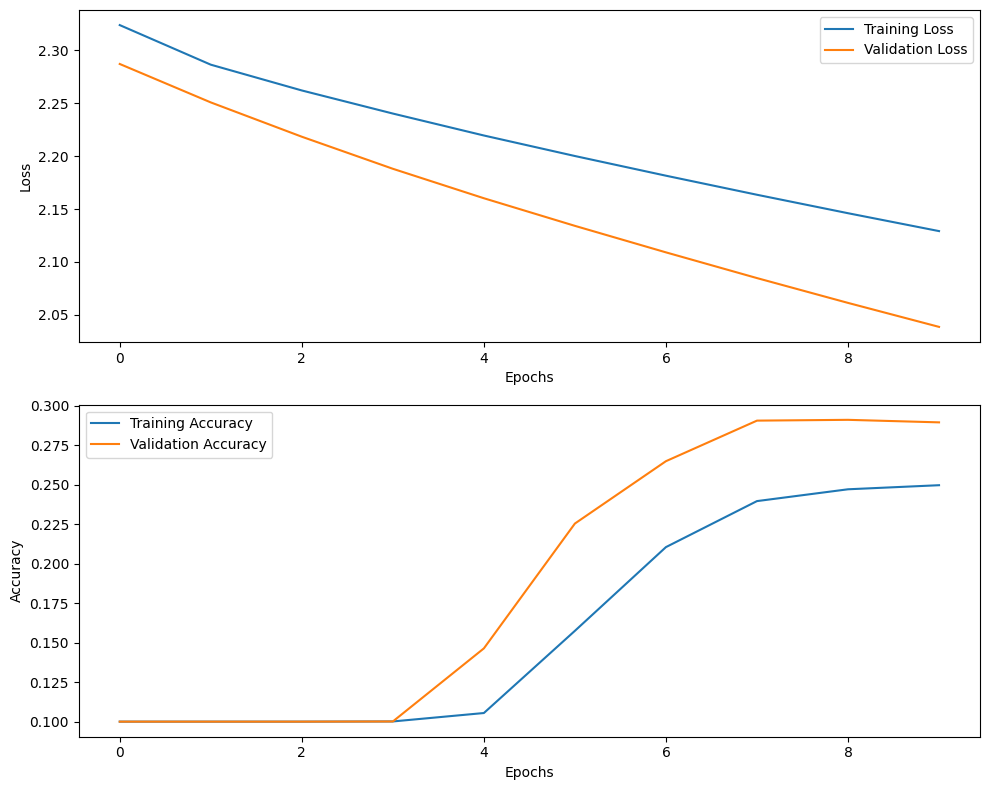

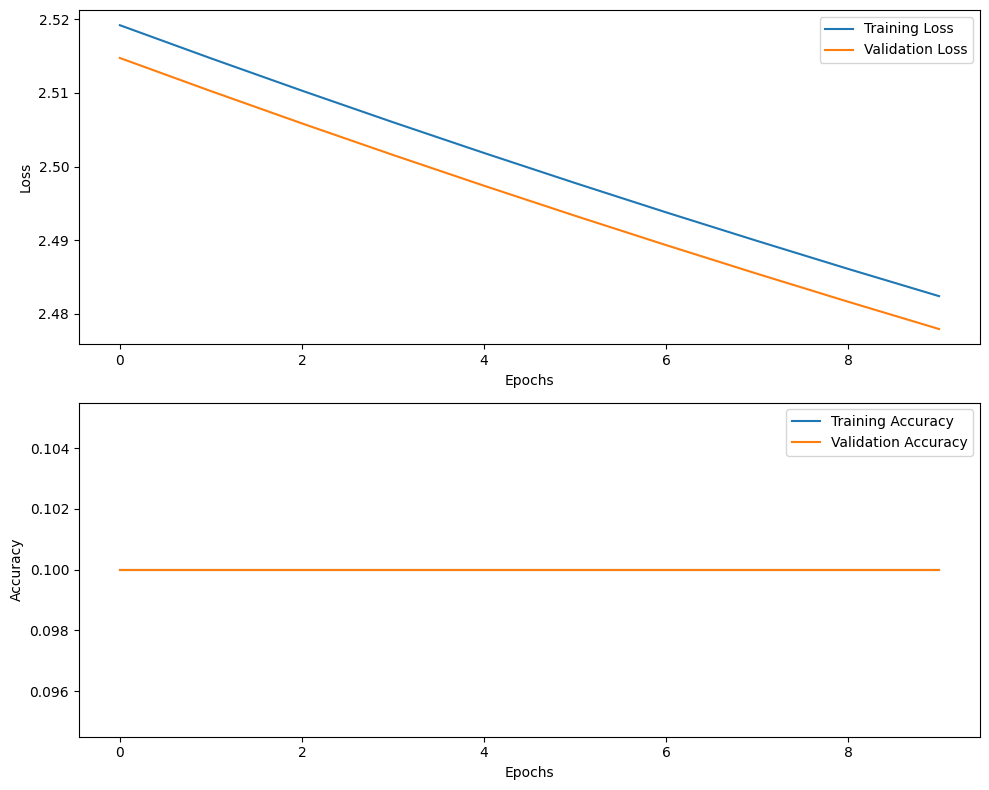

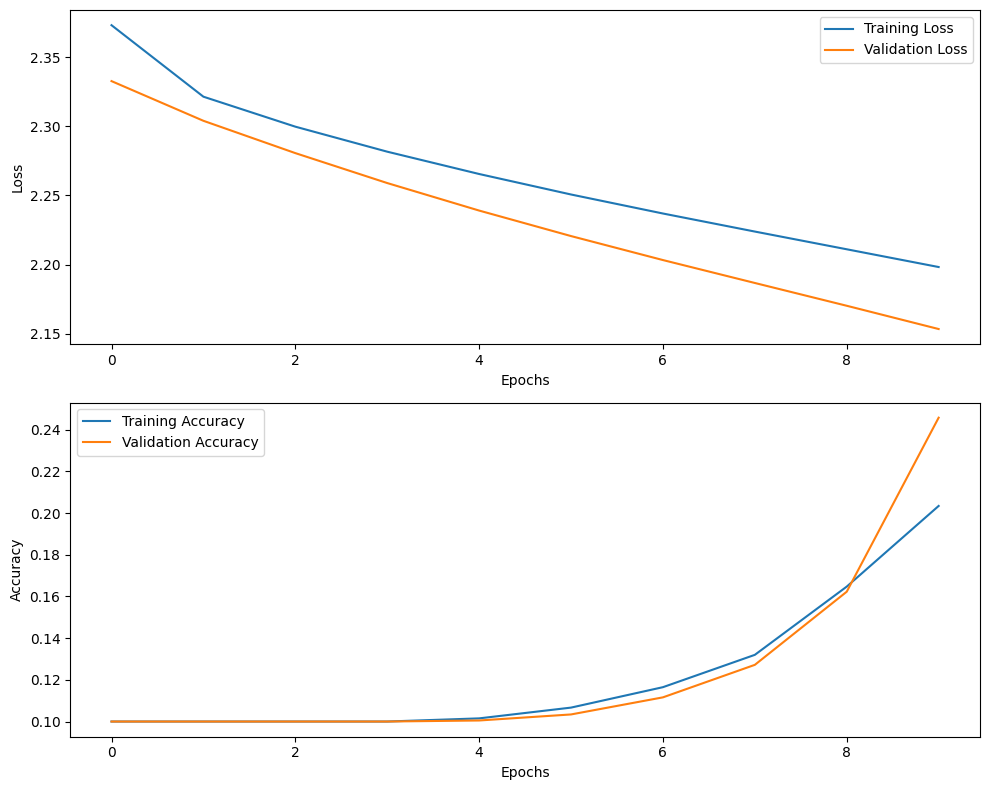

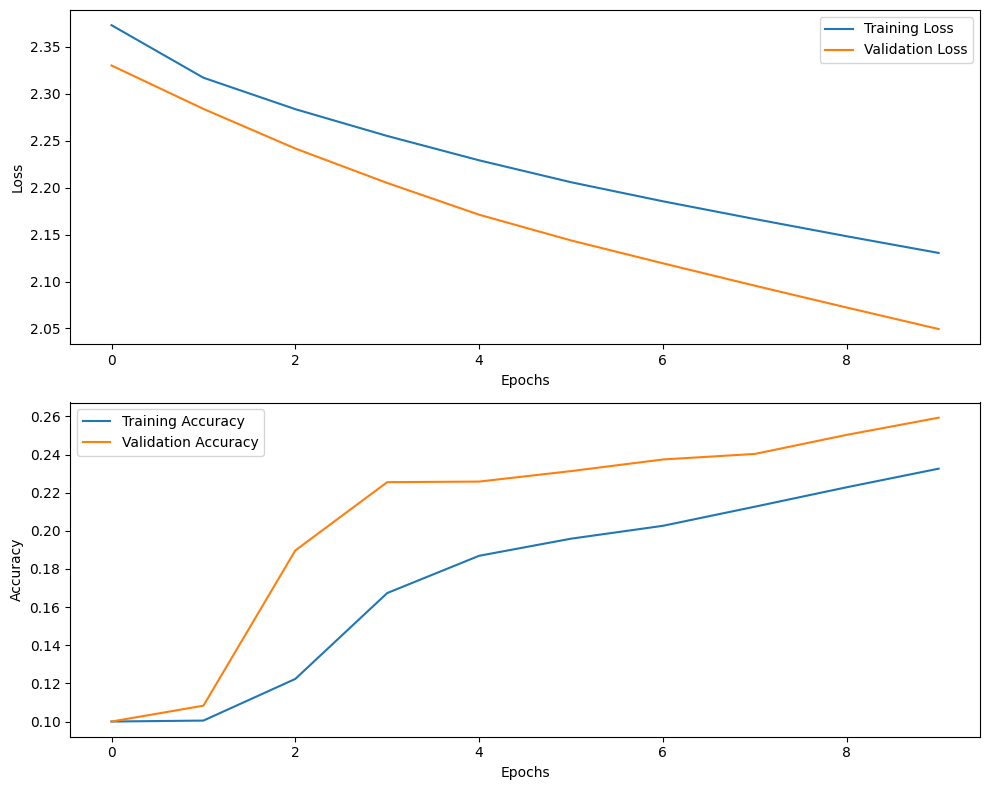

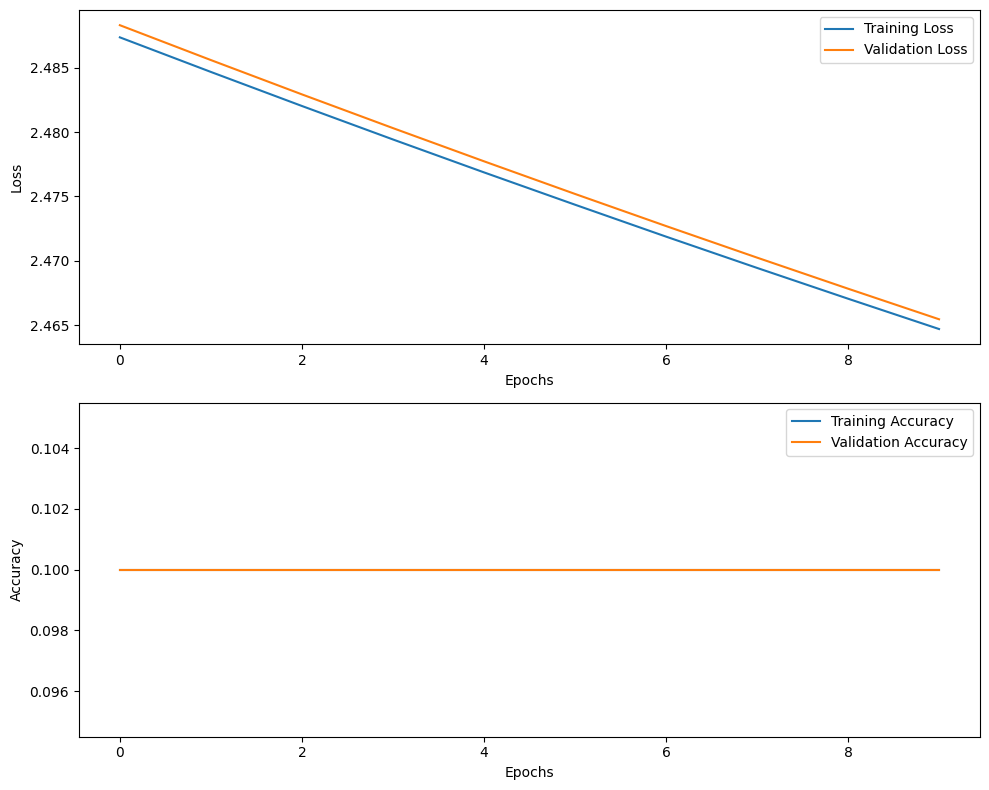

In [15]:
# Experiment name
experiment_name = "Experiment-6: Too low learning rate"
# Define sub-experiments
experiment = ['Sub Experiment-1', 'Sub Experiment-2', 'Sub Experiment-3', 'Sub Experiment-4', 'Sub Experiment-5']
# Define neural network architecture
hidden_layers = [20, 10]  # Two hidden layers as defined in notebook given
# Define learning rates for each sub-experiment
learning_rate = 0.00001 # for too low learning rate
# Define optimizers for each sub-experiment
optimizers = [keras.optimizers.Adam, keras.optimizers.SGD, keras.optimizers.RMSprop, keras.optimizers.Adam, keras.optimizers.SGD]
# Iterate over each sub-experiment
for parameter in experiment:
    # Train model for the current sub-experiment
    # Call the train_model function with experiment parameters
    train_model(
        experiment_name,  # Experiment name
        parameter,  # Sub-experiment name
        x_train, y_train,  # Training data
        x_test, y_test,  # Testing data
        hidden_layers,  # Neural network architecture
        learning_rate,  # Learning rate
        optimizers[experiment.index(parameter)],  # Optimizer for current sub-experiment
        None, # Regularization is not needed in experiment-6
        momentum = None, # No momentum required in this experiment
        batch_size=None, # No batch size in this experiment
        dropout_rate=None
    )

# Experiment-7: Optimal Learning Rate

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.4005 - accuracy: 0.4664 - val_loss: 0.9865 - val_accuracy: 0.6311
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.2044 - accuracy: 0.5494 - val_loss: 0.9402 - val_accuracy: 0.6353
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.1657 - accuracy: 0.5623 - val_loss: 0.9108 - val_accuracy: 0.6526
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.1424 - accuracy: 0.5709 - val_loss: 0.9156 - val_accuracy: 0.6514
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.1270 - accuracy: 0.5801 - val_loss: 0.9176 - val_accuracy: 0.6506
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.1183 - accuracy: 0.5797 - val_loss: 0.9228 - val_accuracy: 0.6476
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.1061 - accuracy: 0.5859 - val_loss: 0.8713 - val_accuracy:

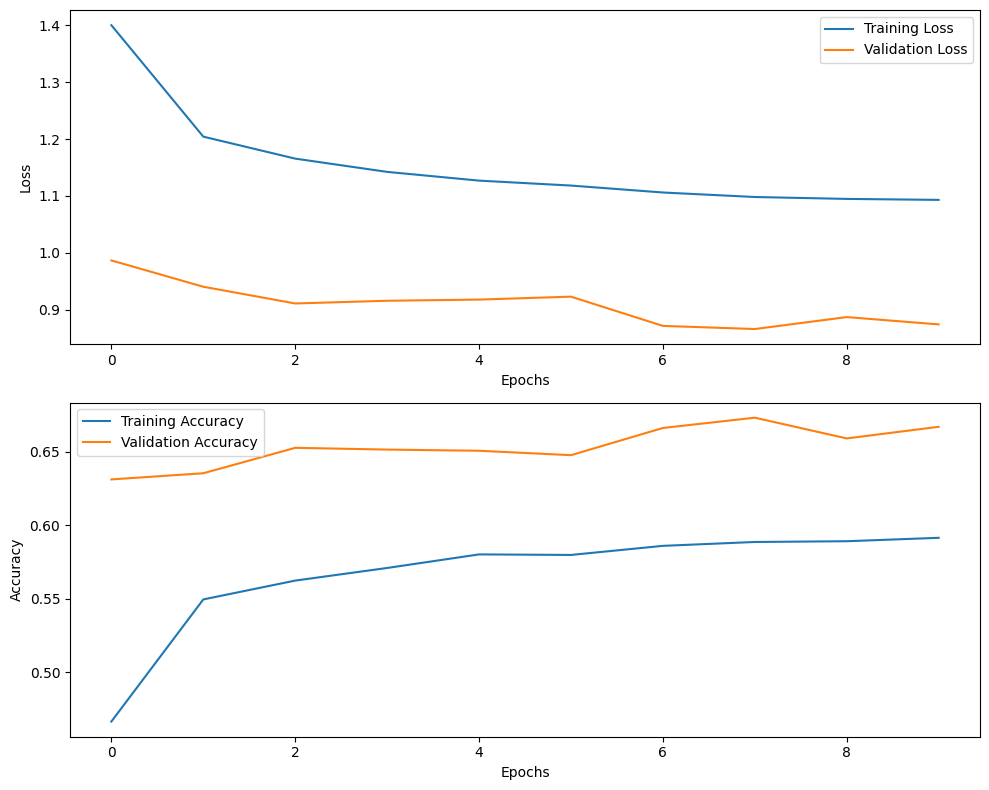

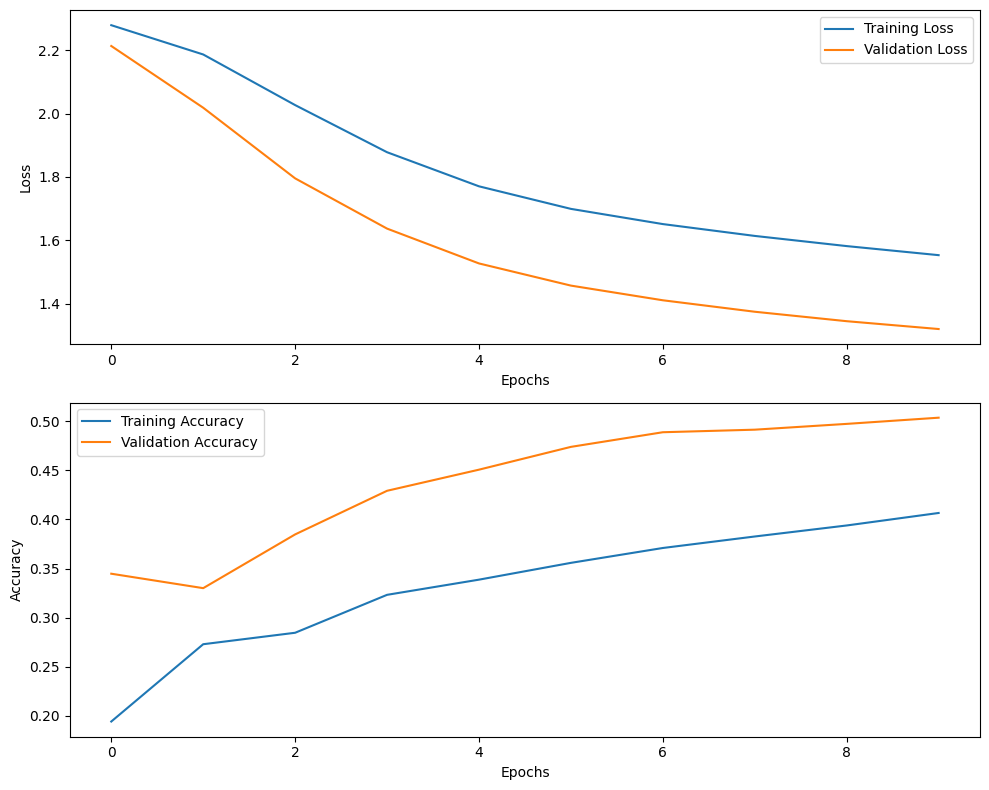

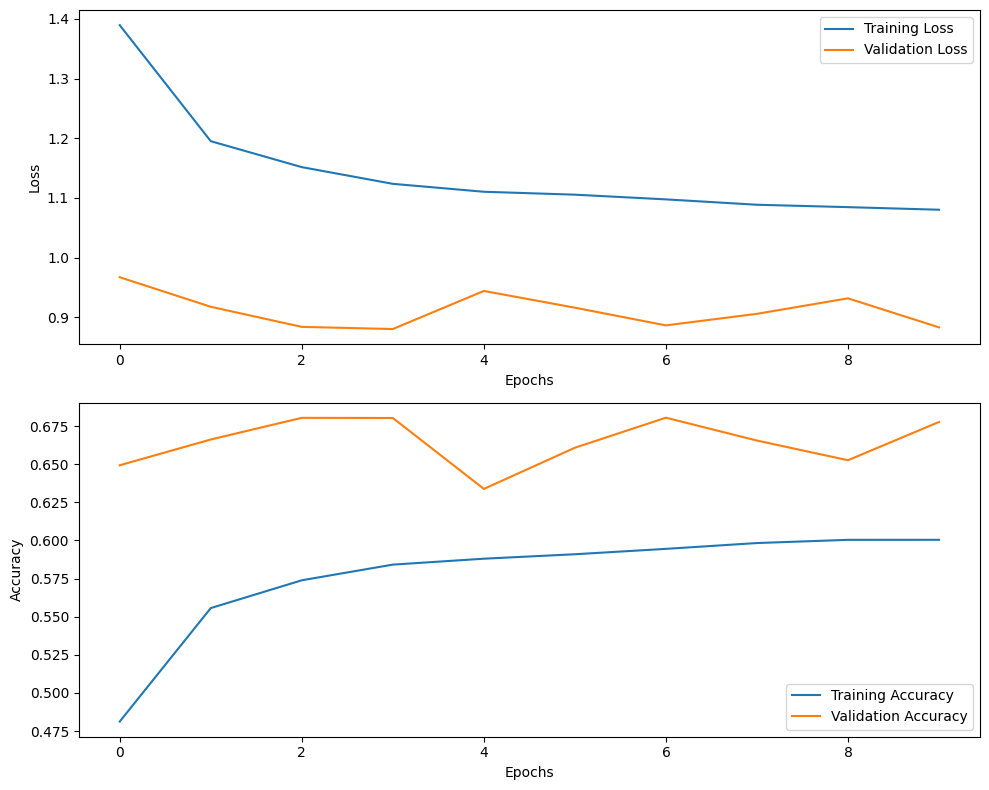

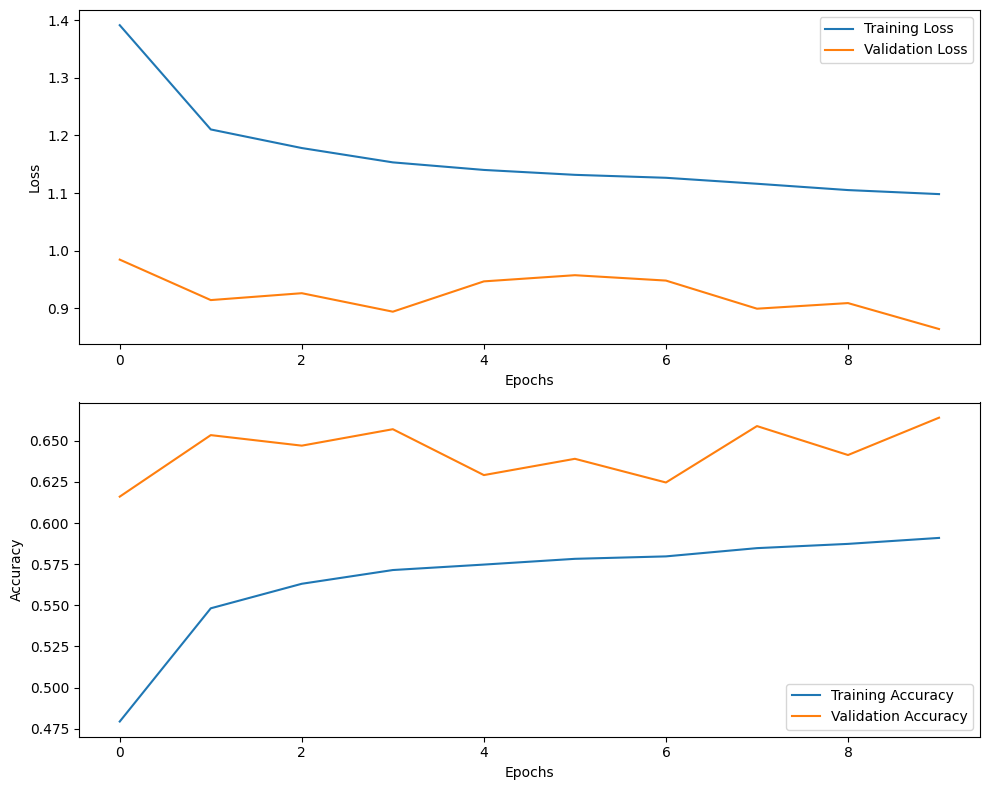

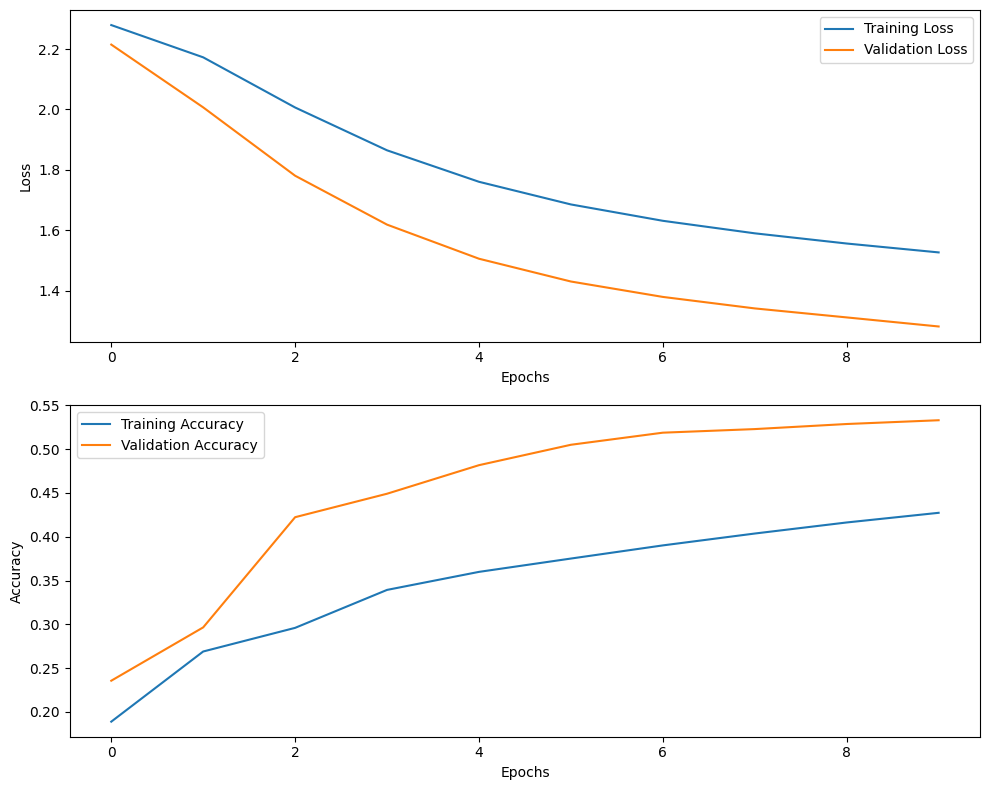

In [16]:
# Experiment name
experiment_name = "Experiment-7: Optimal learning rate"
# Define sub-experiments
experiment = ['Sub Experiment-1', 'Sub Experiment-2', 'Sub Experiment-3', 'Sub Experiment-4', 'Sub Experiment-5']
# Define neural network architecture
hidden_layers = [20, 10]  # Two hidden layers as defined in notebook given
# Define learning rates for each sub-experiment
learning_rate = 0.01 # for optimal learning rate
# Define optimizers for each sub-experiment
optimizers = [keras.optimizers.Adam, keras.optimizers.SGD, keras.optimizers.RMSprop, keras.optimizers.Adam, keras.optimizers.SGD]
# Iterate over each sub-experiment
for parameter in experiment:
    # Train model for the current sub-experiment
    # Call the train_model function with experiment parameters
    train_model(
        experiment_name,  # Experiment name
        parameter,  # Sub-experiment name
        x_train, y_train,  # Training data
        x_test, y_test,  # Testing data
        hidden_layers,  # Neural network architecture
        learning_rate,  # Learning rate
        optimizers[experiment.index(parameter)],  # Optimizer for current sub-experiment
        None, # Regularization is not needed in experiment-7
        momentum = None, # No momentum required in this experiment
        batch_size=None, # No batch size in this experiment
        dropout_rate=None
    )

# Experiment-8: Optimal learning rate with momentum

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 2.2306 - accuracy: 0.2238 - val_loss: 2.0097 - val_accuracy: 0.3702
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.9407 - accuracy: 0.3137 - val_loss: 1.5833 - val_accuracy: 0.4909
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.7185 - accuracy: 0.3771 - val_loss: 1.4005 - val_accuracy: 0.5092
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 1.6073 - accuracy: 0.4059 - val_loss: 1.3124 - val_accuracy: 0.5477
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5301 - accuracy: 0.4392 - val_loss: 1.2372 - val_accuracy: 0.5933
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.4596 - accuracy: 0.4746 - val_loss: 1.1772 - val_accuracy: 0.6128
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.3947 - accuracy: 0.5015 - val_loss: 1.1188 - val_accuracy:

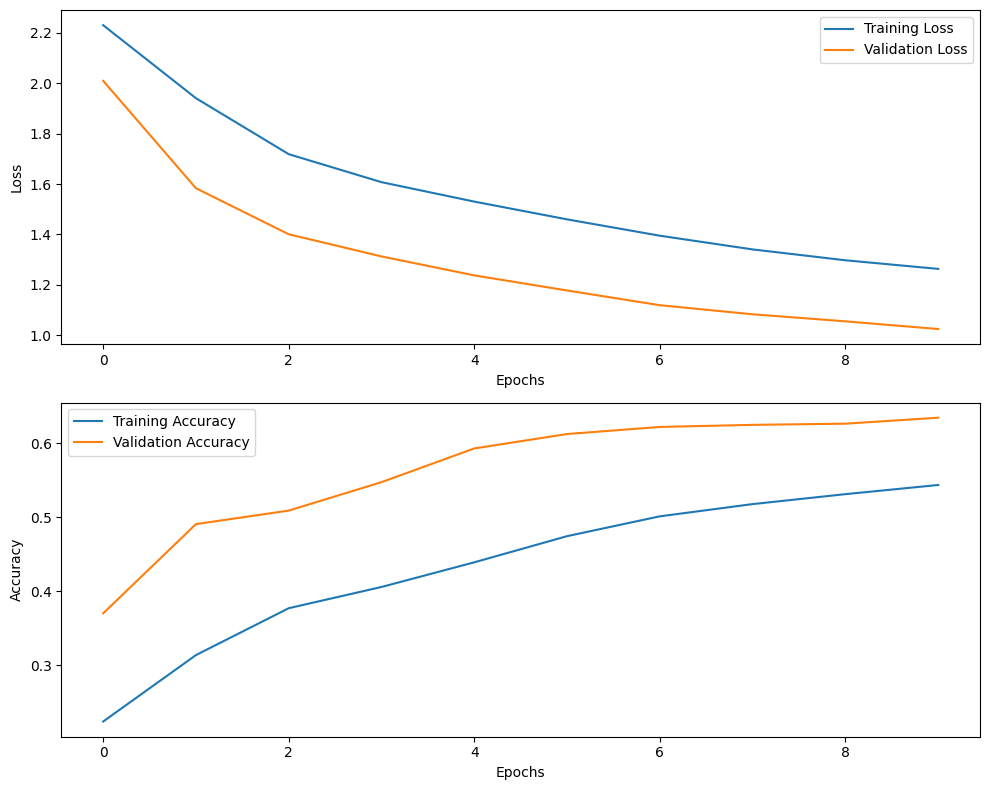

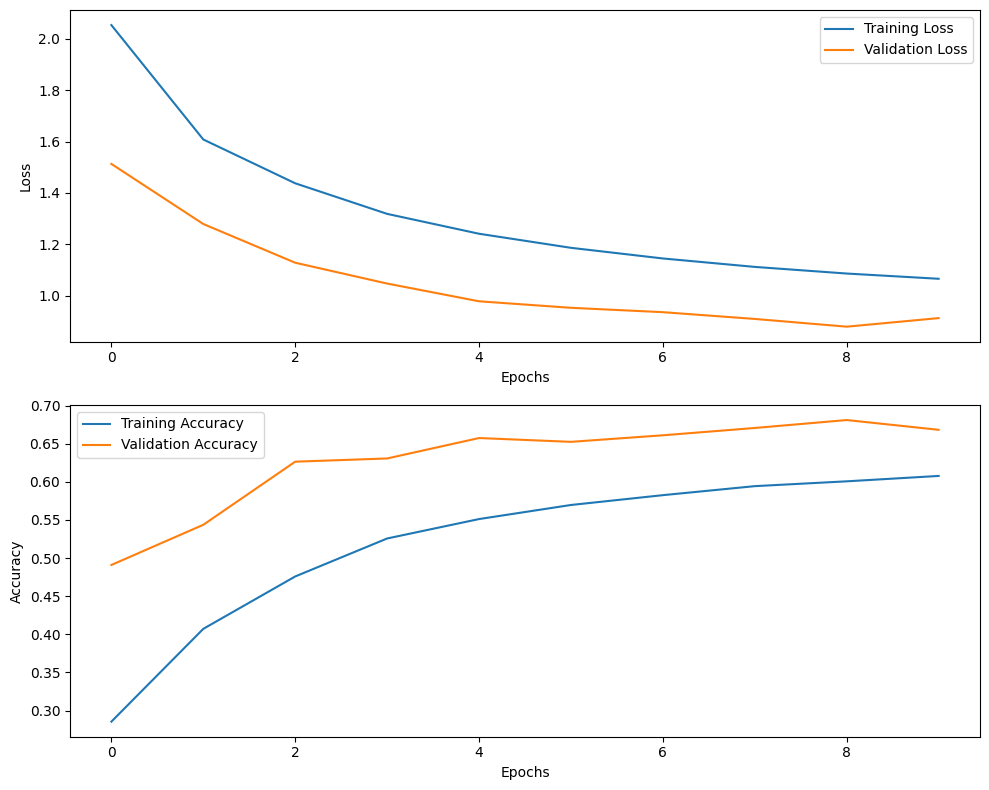

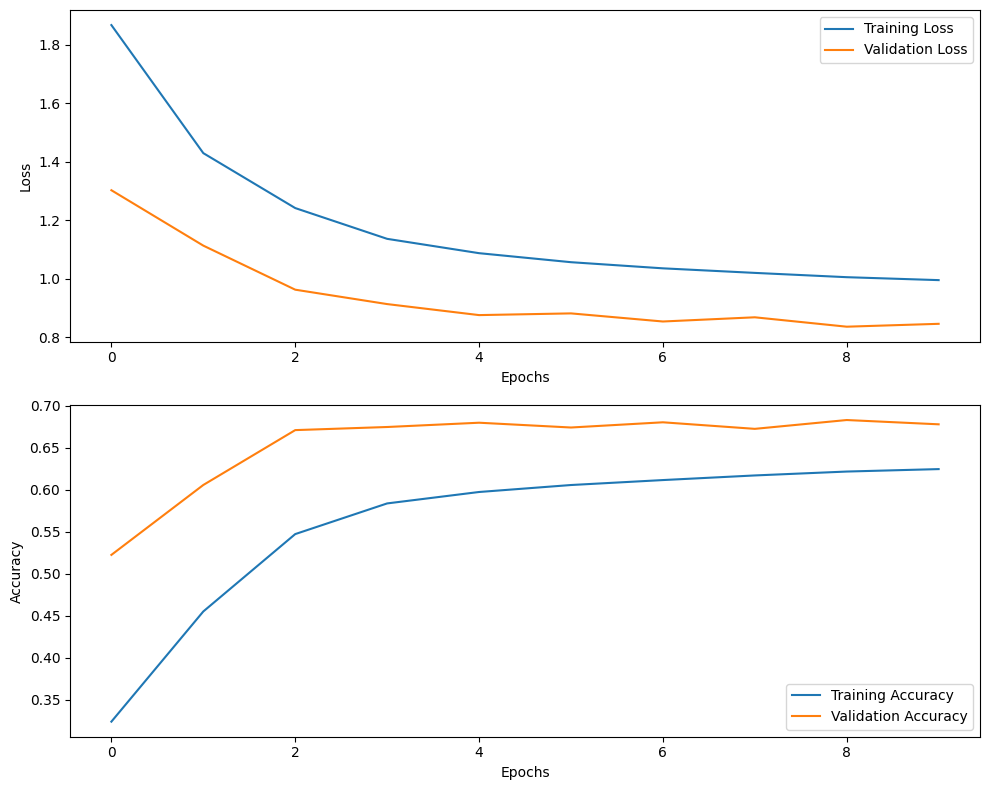

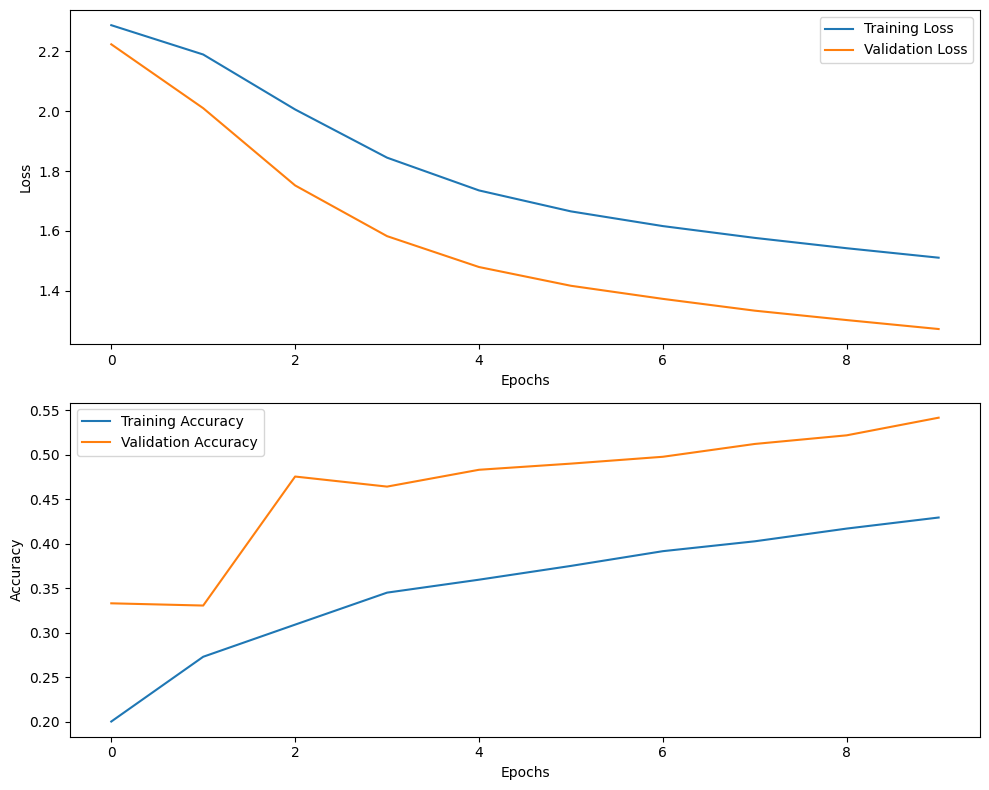

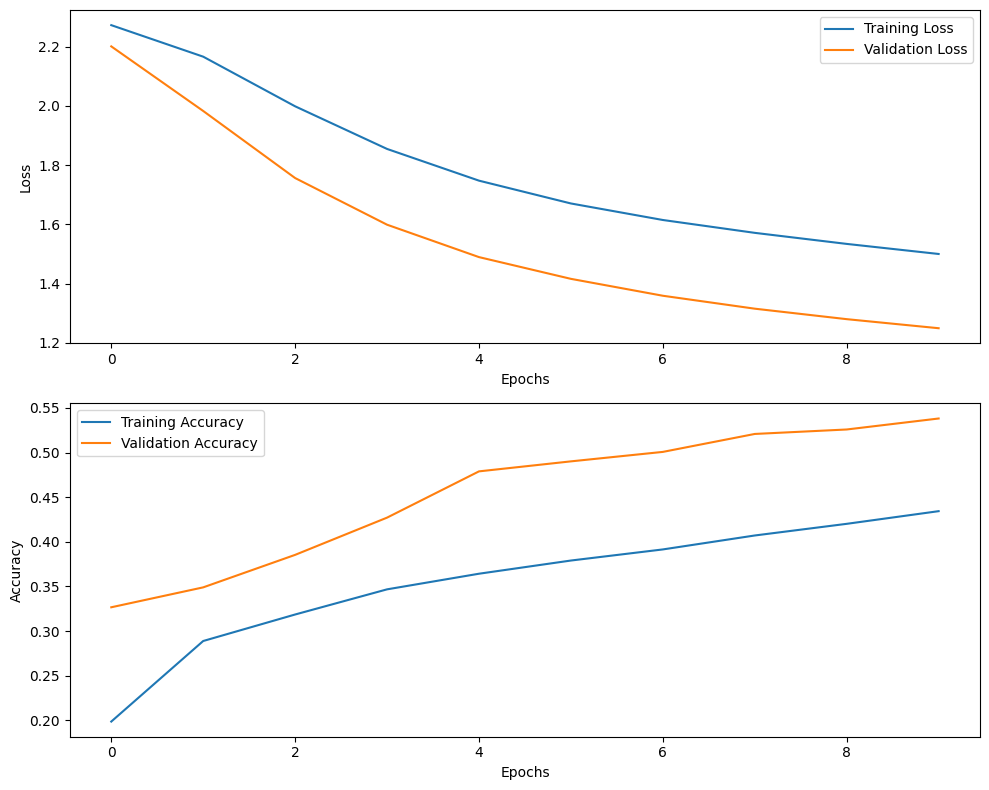

In [17]:
# Experiment name
experiment_name = "Experiment-8: Optimal learning rate with momentum"
# Define sub-experiments
experiment = ['Sub Experiment-1', 'Sub Experiment-2', 'Sub Experiment-3', 'Sub Experiment-4', 'Sub Experiment-5']
# Define neural network architecture
hidden_layers = [20, 10]  # Two hidden layers as defined in notebook given
# Define learning rates for each sub-experiment
learning_rate = 0.01 # for optimal learning rate
# Define optimizers for each sub-experiment
optimizers = keras.optimizers.SGD
momentum = [0.5, 0.8, 0.9, 0.2,0.1]
# Iterate over each sub-experiment
for parameter in experiment:
    # Train model for the current sub-experiment
    # Call the train_model function with experiment parameters
    train_model(
        experiment_name,  # Experiment name
        parameter,  # Sub-experiment name
        x_train, y_train,  # Training data
        x_test, y_test,  # Testing data
        hidden_layers,  # Neural network architecture
        learning_rate,  # Learning rate
        optimizers,  # Optimizer for current sub-experiment
        None, # Regularization is not needed in experiment-7
        momentum[experiment.index(parameter)],  # momentum required in this experiment
        batch_size=None, # No batch size in this experiment
        dropout_rate=None
    )

# Experiment-9: With Batch Size

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 2.2686 - accuracy: 0.2182 - val_loss: 2.1367 - val_accuracy: 0.3472
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 2.0587 - accuracy: 0.3090 - val_loss: 1.7256 - val_accuracy: 0.3923
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.7886 - accuracy: 0.3576 - val_loss: 1.4739 - val_accuracy: 0.4872
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.6498 - accuracy: 0.3911 - val_loss: 1.3663 - val_accuracy: 0.5225
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5698 - accuracy: 0.4200 - val_loss: 1.2873 - val_accuracy: 0.5490
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5022 - accuracy: 0.4483 - val_loss: 1.2340 - val_accuracy: 0.5632
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.4420 - accuracy: 0.4733 - val_loss: 1.1840 - val_accuracy:

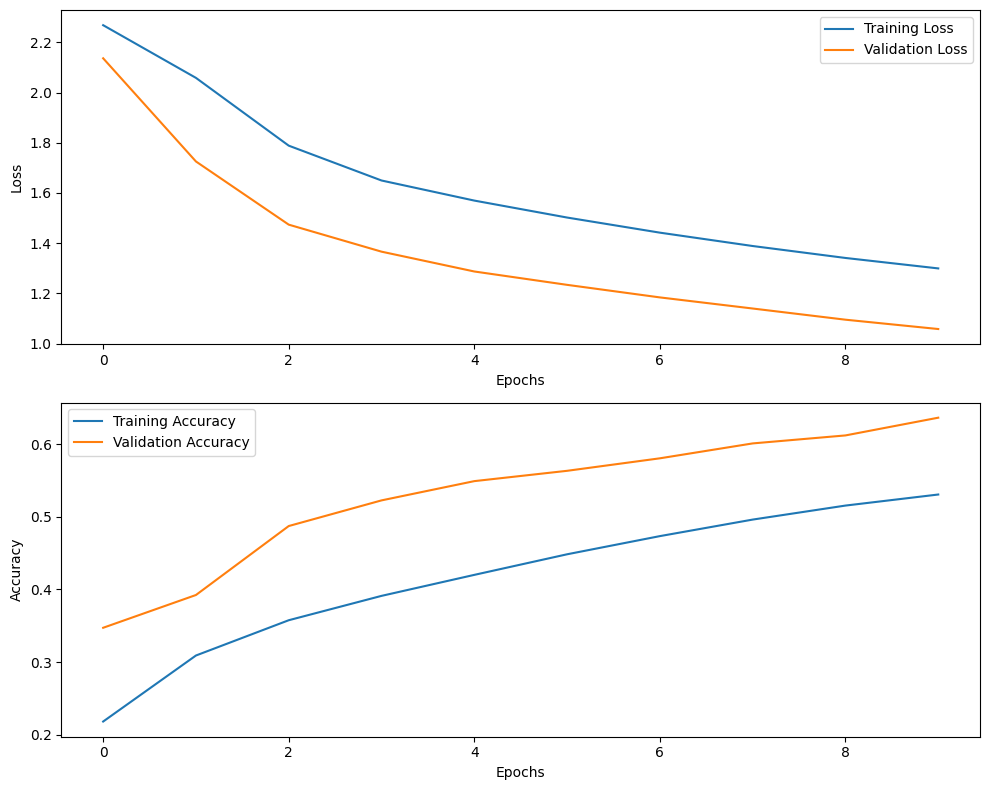

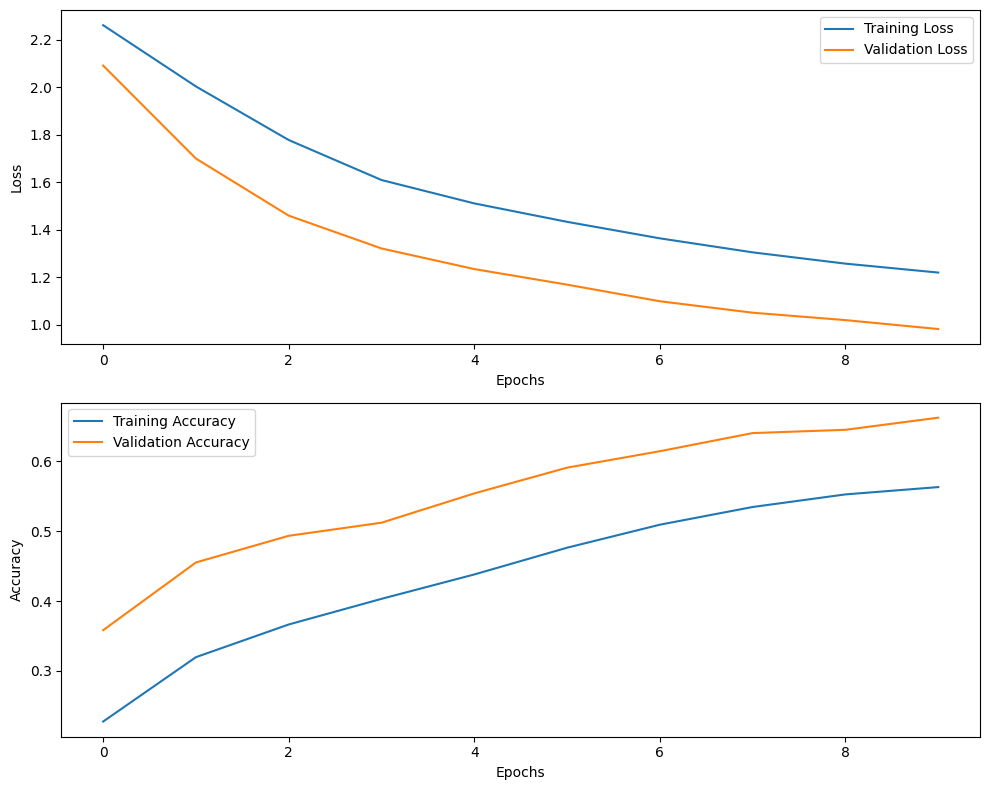

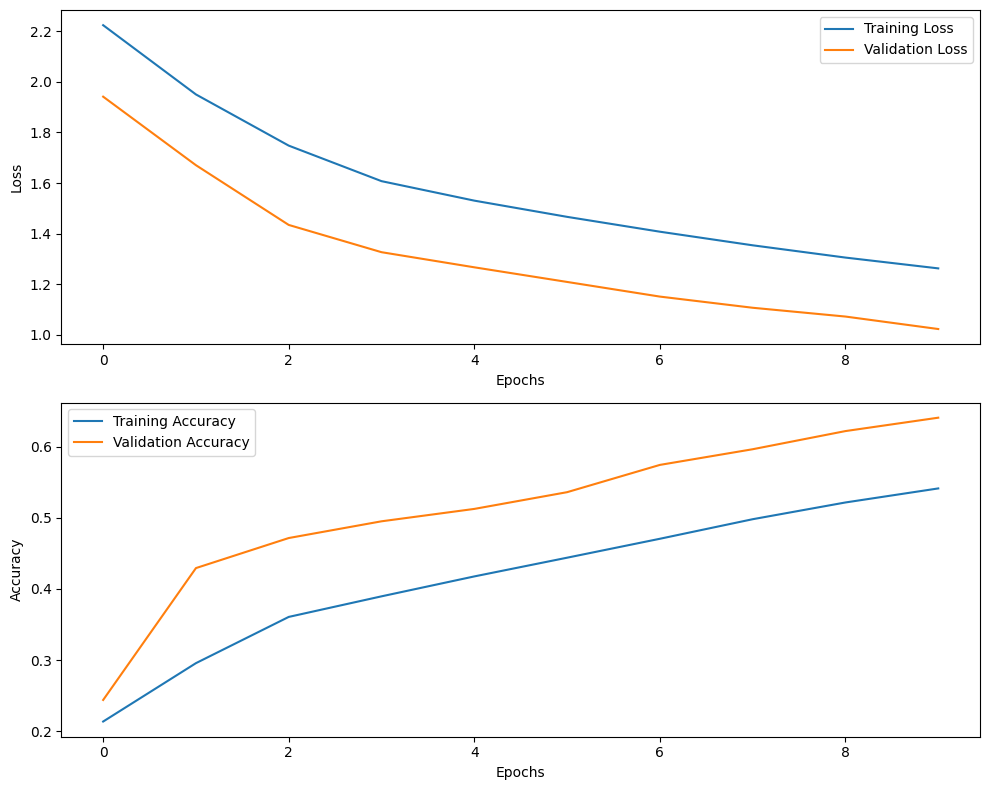

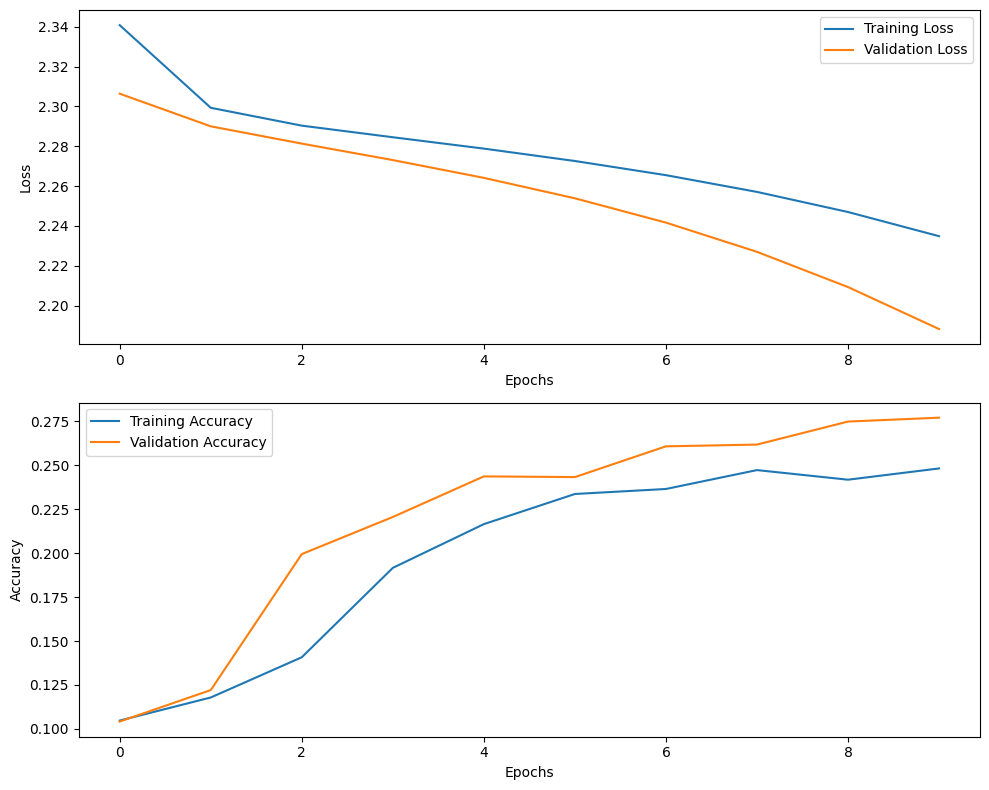

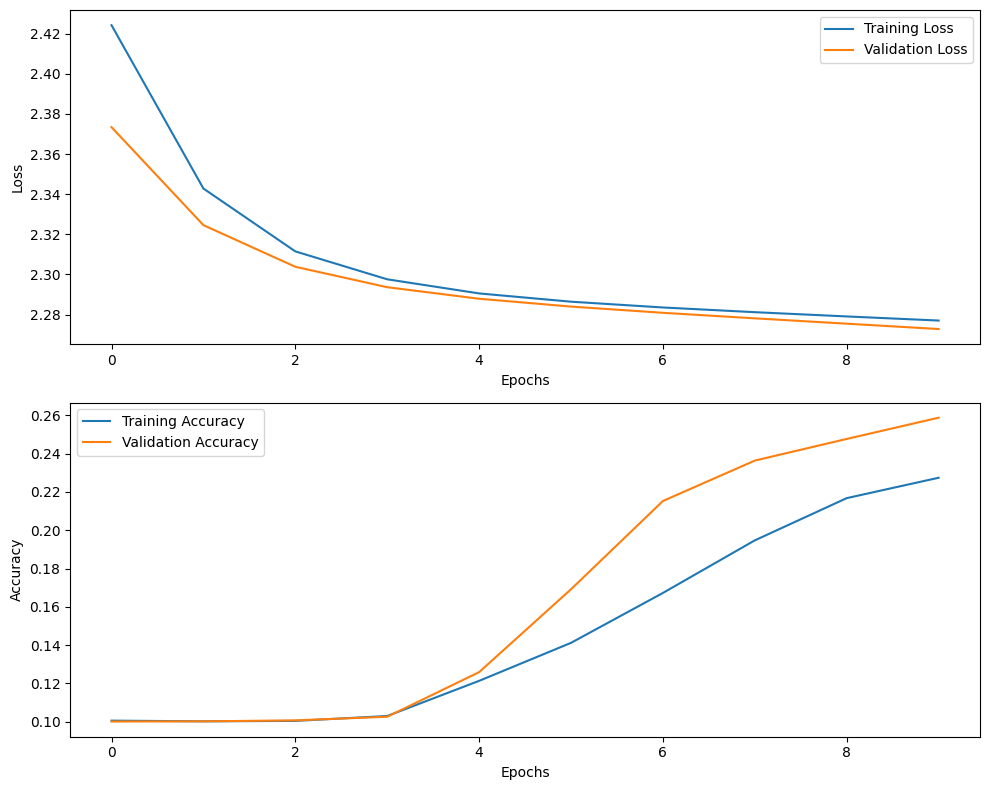

In [18]:
# Experiment name
experiment_name = "Experiment-9: With Batch Size"
# Define sub-experiments
experiment = ['Sub Experiment-1', 'Sub Experiment-2', 'Sub Experiment-3', 'Sub Experiment-4', 'Sub Experiment-5']
# Define neural network architecture
hidden_layers = [20, 10]  # Two hidden layers as defined in notebook given
# Define learning rates for each sub-experiment
learning_rate = 0.01 # for optimal learning rate
# Define optimizers for each sub-experiment
optimizers = keras.optimizers.SGD
momentum = [0.5, 0.8, 0.9, 0.2,0.1]
batch_size = [32,64,128,256,512]
# Iterate over each sub-experiment
for parameter in experiment:
    # Train model for the current sub-experiment
    # Call the train_model function with experiment parameters
    train_model(
        experiment_name,  # Experiment name
        parameter,  # Sub-experiment name
        x_train, y_train,  # Training data
        x_test, y_test,  # Testing data
        hidden_layers,  # Neural network architecture
        learning_rate,  # Learning rate
        optimizers,  # Optimizer for current sub-experiment
        None, # Regularization is not needed in experiment-7
        momentum[experiment.index(parameter)],  # momentum required in this experiment
        batch_size[experiment.index(parameter)], # batch size is required in this experiment
        dropout_rate=None
    )

# Experiment-10: Batch size with Bigger Model

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 2.0515 - accuracy: 0.3035 - val_loss: 1.5452 - val_accuracy: 0.4839
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.6205 - accuracy: 0.4271 - val_loss: 1.2154 - val_accuracy: 0.6011
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 1.4878 - accuracy: 0.4644 - val_loss: 1.1330 - val_accuracy: 0.6260
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 1.4291 - accuracy: 0.4839 - val_loss: 1.1038 - val_accuracy: 0.6221
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 1.3852 - accuracy: 0.4987 - val_loss: 1.0683 - val_accuracy: 0.6286
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 1.3442 - accuracy: 0.5138 - val_loss: 1.0576 - val_accuracy: 0.6277
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.3041 - accuracy: 0.5271 - val_loss: 1.0215 - val_accuracy:

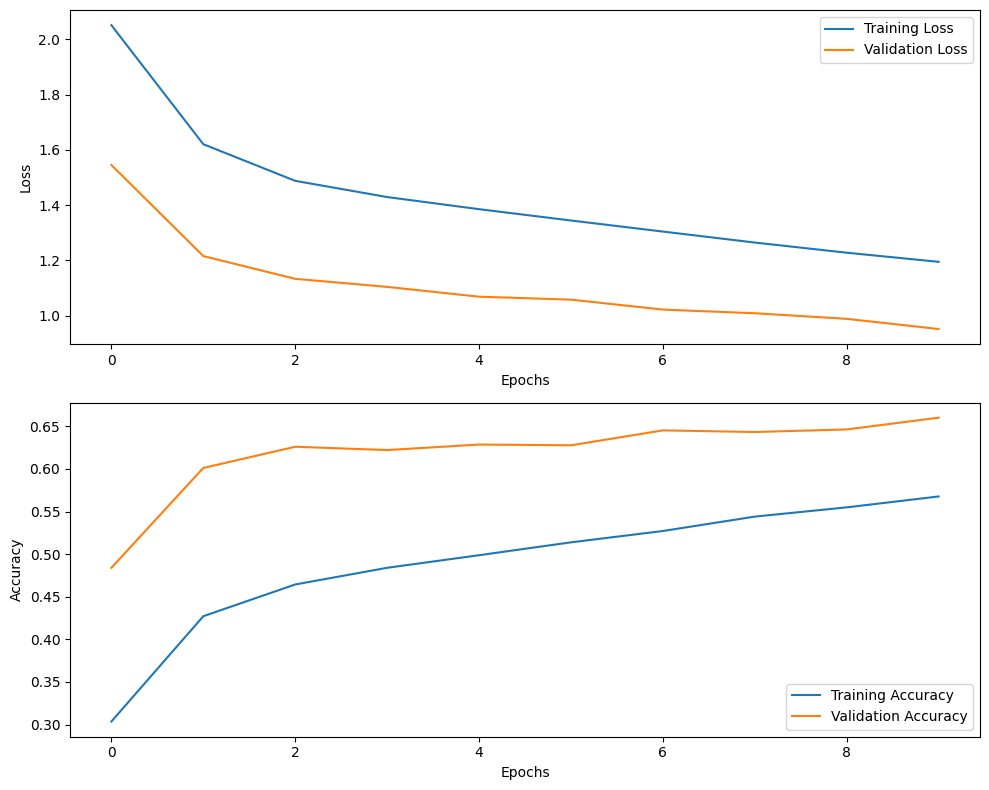

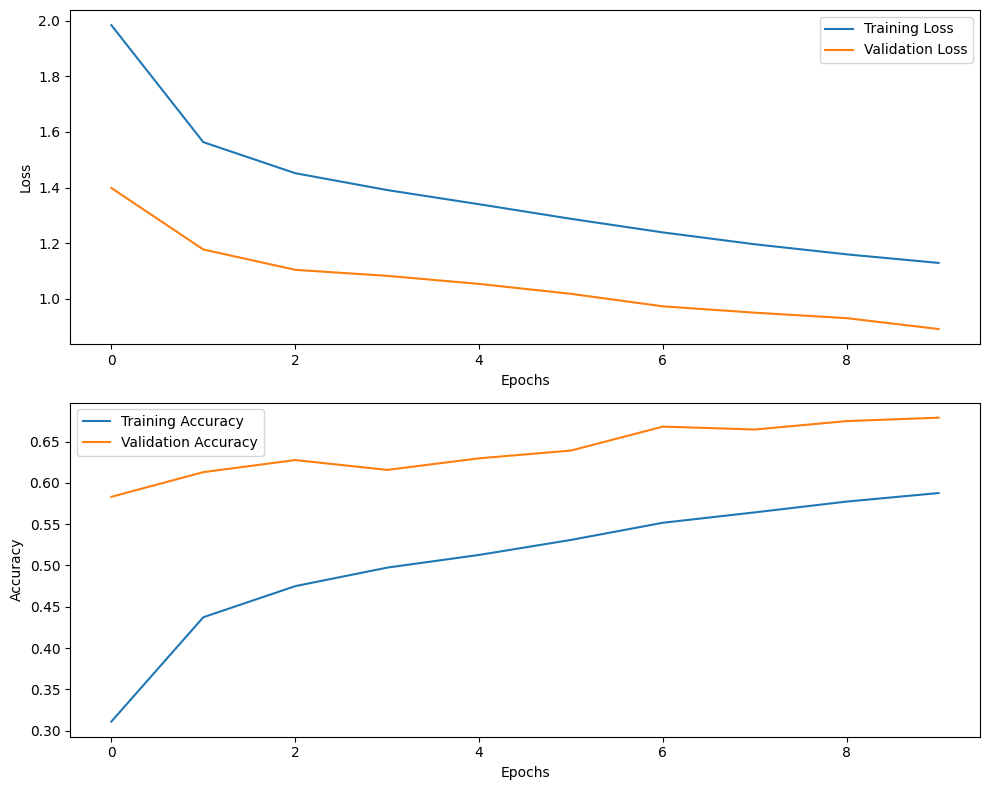

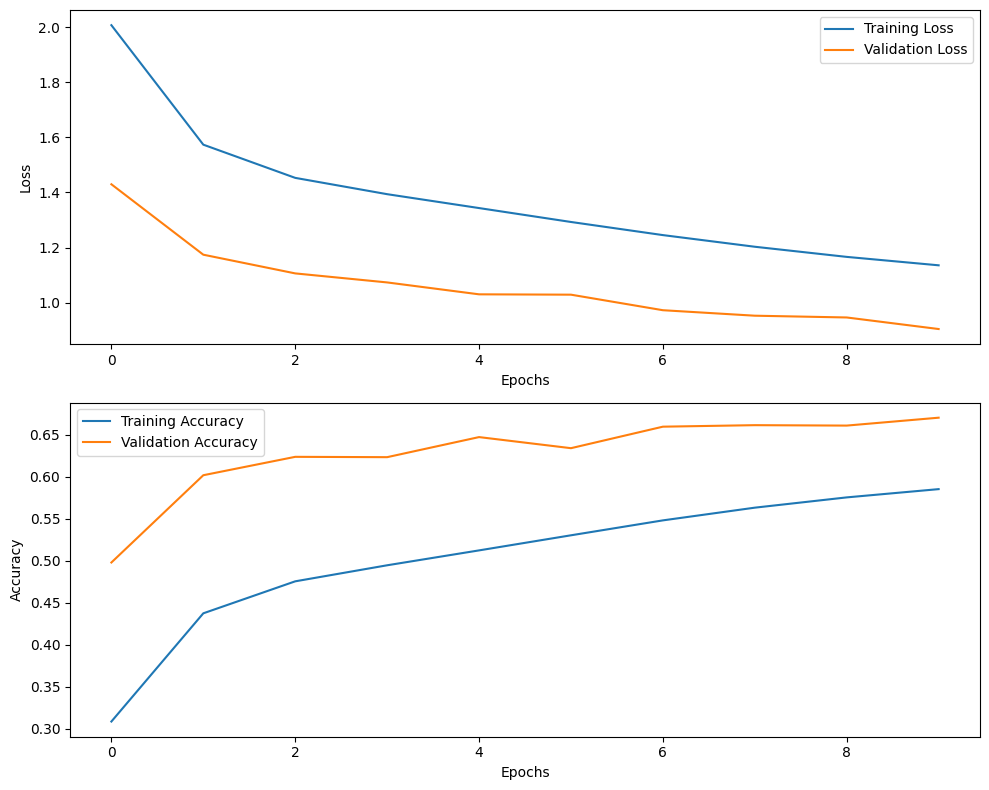

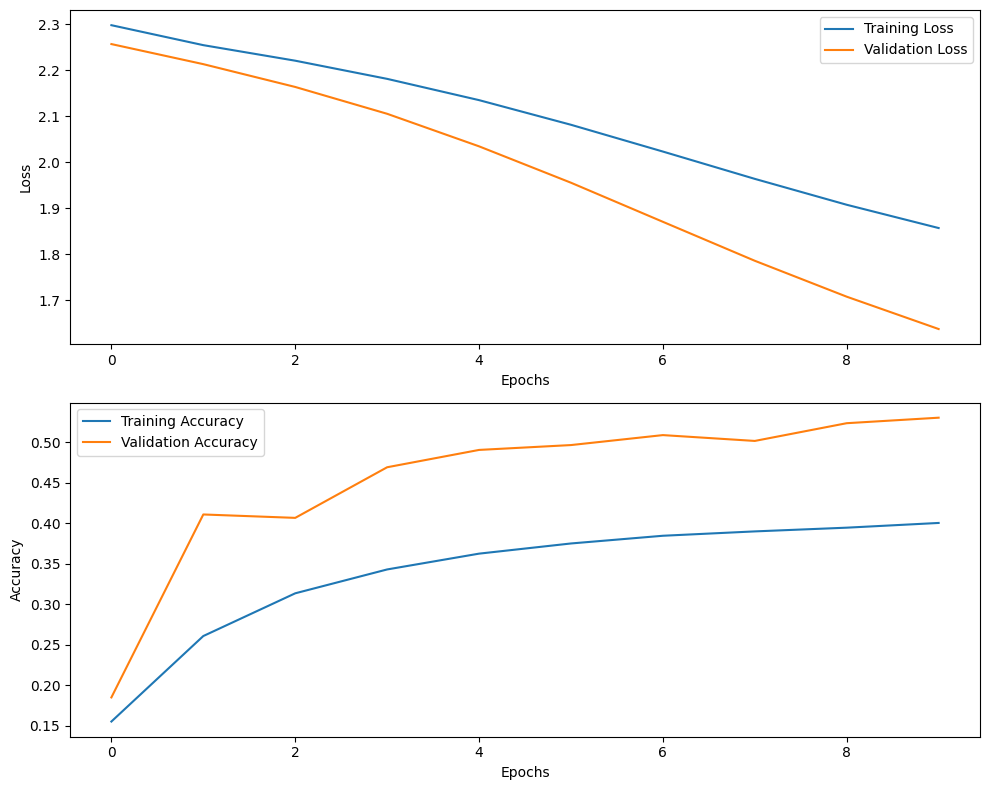

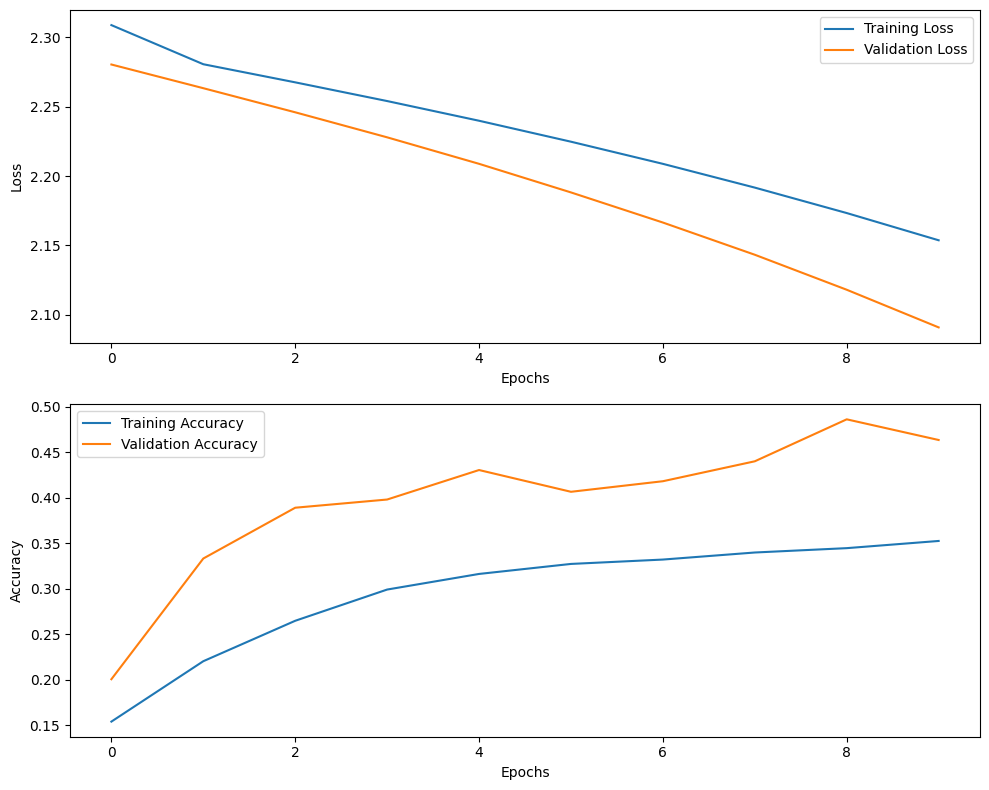

In [19]:
# Experiment name
experiment_name = "Experiment-10: Batch size with no momentum"
# Define sub-experiments
experiment = ['Sub Experiment-1', 'Sub Experiment-2', 'Sub Experiment-3', 'Sub Experiment-4', 'Sub Experiment-5']
# Define neural network architecture
hidden_layers = [256, 128]  # Two hidden layers as defined in notebook given
# Define learning rates for each sub-experiment
learning_rate = 0.01 # for optimal learning rate
# Define optimizers for each sub-experiment
optimizers = keras.optimizers.SGD
momentum = [0.5, 0.8, 0.9, 0.2,0.1]
batch_size = [32,64,128,256,512]
# Iterate over each sub-experiment
for parameter in experiment:
    # Train model for the current sub-experiment
    # Call the train_model function with experiment parameters
    train_model(
        experiment_name,  # Experiment name
        parameter,  # Sub-experiment name
        x_train, y_train,  # Training data
        x_test, y_test,  # Testing data
        hidden_layers,  # Neural network architecture
        learning_rate,  # Learning rate
        optimizers,  # Optimizer for current sub-experiment
        None, # Regularization is not needed in experiment-7
        momentum[experiment.index(parameter)],  # momentum required in this experiment
        batch_size[experiment.index(parameter)], # batch size is required in this experiment
        dropout_rate=None
    )